In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install captum


1.13.0+cu116
     |████████████████████████████████| 9.4 MB 7.3 MB/s 
     |████████████████████████████████| 4.6 MB 7.5 MB/s 
     |████████████████████████████████| 280 kB 7.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.5 MB/s 


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from sklearn import metrics
from copy import deepcopy
from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv
import torch.nn as nn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'SA'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [5]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [6]:
torch.manual_seed(123456)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [7]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 7

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Model Designing**

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.elu(x)

        x = self.conv2(x, edge_index)
        x = torch.nn.functional.elu(x)

        #x = self.conv3(x, edge_index)
        #x = torch.nn.functional.elu(x)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

SA_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
print(SA_model_GCN)

GCN(
  (conv1): GCNConv(7, 7)
  (conv2): GCNConv(7, 7)
  (lin): Linear(in_features=7, out_features=2, bias=True)
)


In [9]:
SA_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
SA_model_GCN.eval()

GCN(
  (conv1): GCNConv(7, 7)
  (conv2): GCNConv(7, 7)
  (lin): Linear(in_features=7, out_features=2, bias=True)
)

In [10]:
SA_optimizer = torch.optim.RMSprop(SA_model_GCN.parameters(), lr=0.001)

In [11]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [12]:
def loading_model(load_index):
  SA_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
  SA_optimizer = torch.optim.Adam(params = SA_model_GCN.parameters(), lr=1e-4)
  checkpoint = torch.load("/content/drive/My Drive/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  SA_model_GCN.load_state_dict(checkpoint['model_state_dict'])
  SA_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return SA_model_GCN, SA_optimizer, epoch

In [13]:
def visualize_losses(g_losses, epoch_history):
  g_losses_list = torch.stack(g_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("SA Model Loss in Epoch: " + str(epoch_history))

  ax.plot(g_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  




# **Traning Configurations**

In [14]:
def train_step():
  SA_loss_batch = []

  SA_model_GCN.train()
  SA_optimizer.zero_grad()
  for batched_data in train_loader:
    SA_out = SA_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    SA_loss = loss_calculations(SA_out, batched_data.y)
    SA_loss_batch.append(SA_loss)
    SA_loss.backward()
    SA_optimizer.step()

  SA_optimizer.step()

  return torch.mean(torch.tensor(SA_loss_batch))


In [15]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [16]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  SA_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    SA_model_training_loss = train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {SA_model_training_loss:.4f}')

    SA_training_loss_per_epoch.append(SA_model_training_loss)
    #break

    if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(SA_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': SA_model_GCN.state_dict(), 'optimizer_state_dict': SA_optimizer.state_dict(), 'loss': SA_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss





<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-17-d17a5d269471>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if load_index is not 0:


Epoch: 001, SA Model Loss: 0.6823
Epoch: 002, SA Model Loss: 0.6519
Epoch: 003, SA Model Loss: 0.6509
Epoch: 004, SA Model Loss: 0.6147
Epoch: 005, SA Model Loss: 0.6542
Epoch: 006, SA Model Loss: 0.6416
Epoch: 007, SA Model Loss: 0.6513
Epoch: 008, SA Model Loss: 0.6150
Epoch: 009, SA Model Loss: 0.6354
Epoch: 010, SA Model Loss: 0.6203
Epoch: 011, SA Model Loss: 0.6109
Epoch: 012, SA Model Loss: 0.6212
Epoch: 013, SA Model Loss: 0.6127
Epoch: 014, SA Model Loss: 0.5989
Epoch: 015, SA Model Loss: 0.6428
Epoch: 016, SA Model Loss: 0.6126
Epoch: 017, SA Model Loss: 0.6263
Epoch: 018, SA Model Loss: 0.6451
Epoch: 019, SA Model Loss: 0.6059
Epoch: 020, SA Model Loss: 0.5957
Epoch: 021, SA Model Loss: 0.6306
Epoch: 022, SA Model Loss: 0.6052
Epoch: 023, SA Model Loss: 0.6439
Epoch: 024, SA Model Loss: 0.6055
Epoch: 025, SA Model Loss: 0.6336
Epoch: 026, SA Model Loss: 0.5999
Epoch: 027, SA Model Loss: 0.5946
Epoch: 028, SA Model Loss: 0.5761
Epoch: 029, SA Model Loss: 0.6075
Epoch: 030, SA

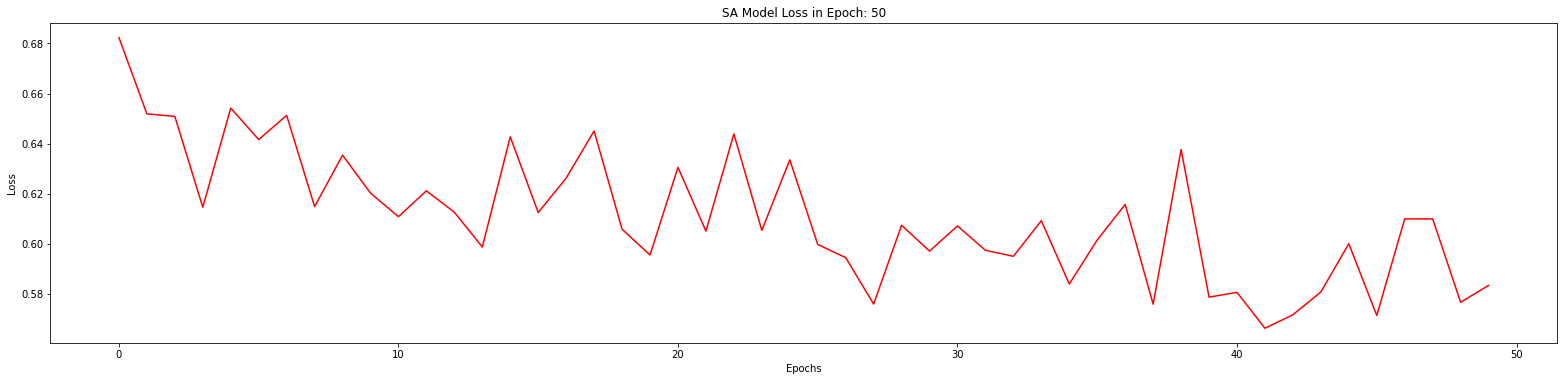

Epoch: 051, SA Model Loss: 0.5769
Epoch: 052, SA Model Loss: 0.5691
Epoch: 053, SA Model Loss: 0.5854
Epoch: 054, SA Model Loss: 0.5999
Epoch: 055, SA Model Loss: 0.6252
Epoch: 056, SA Model Loss: 0.5656
Epoch: 057, SA Model Loss: 0.5610
Epoch: 058, SA Model Loss: 0.5852
Epoch: 059, SA Model Loss: 0.5637
Epoch: 060, SA Model Loss: 0.5876
Epoch: 061, SA Model Loss: 0.5409
Epoch: 062, SA Model Loss: 0.5821
Epoch: 063, SA Model Loss: 0.5598
Epoch: 064, SA Model Loss: 0.5909
Epoch: 065, SA Model Loss: 0.6168
Epoch: 066, SA Model Loss: 0.5715
Epoch: 067, SA Model Loss: 0.5798
Epoch: 068, SA Model Loss: 0.5558
Epoch: 069, SA Model Loss: 0.5846
Epoch: 070, SA Model Loss: 0.5691
Epoch: 071, SA Model Loss: 0.5552
Epoch: 072, SA Model Loss: 0.5363
Epoch: 073, SA Model Loss: 0.5607
Epoch: 074, SA Model Loss: 0.5890
Epoch: 075, SA Model Loss: 0.5474
Epoch: 076, SA Model Loss: 0.5570
Epoch: 077, SA Model Loss: 0.5556
Epoch: 078, SA Model Loss: 0.5402
Epoch: 079, SA Model Loss: 0.5540
Epoch: 080, SA

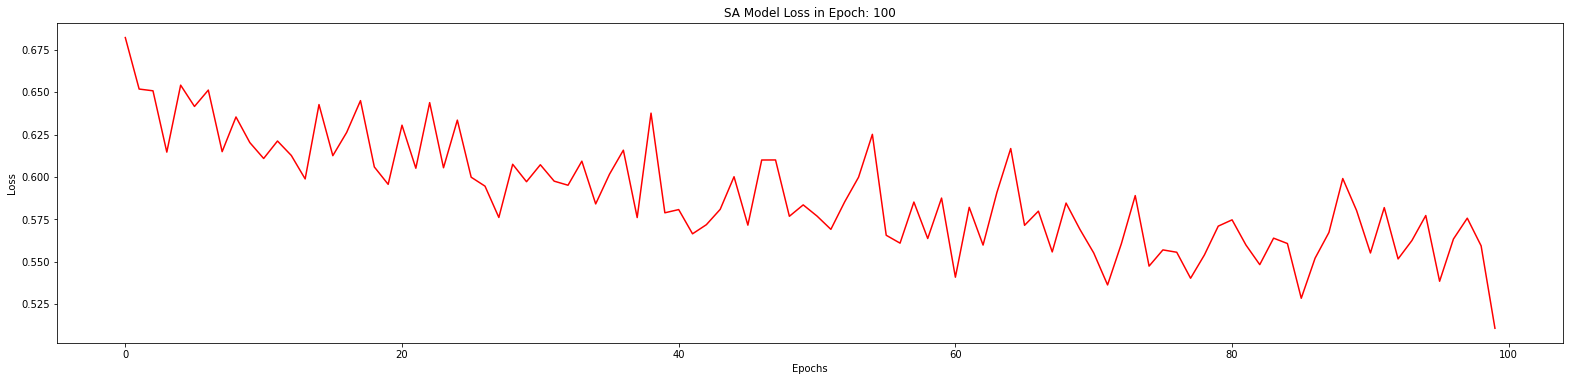

Epoch: 101, SA Model Loss: 0.5678
Epoch: 102, SA Model Loss: 0.5258
Epoch: 103, SA Model Loss: 0.5429
Epoch: 104, SA Model Loss: 0.5674
Epoch: 105, SA Model Loss: 0.5515
Epoch: 106, SA Model Loss: 0.5414
Epoch: 107, SA Model Loss: 0.5333
Epoch: 108, SA Model Loss: 0.5637
Epoch: 109, SA Model Loss: 0.5602
Epoch: 110, SA Model Loss: 0.5378
Epoch: 111, SA Model Loss: 0.5329
Epoch: 112, SA Model Loss: 0.5723
Epoch: 113, SA Model Loss: 0.5573
Epoch: 114, SA Model Loss: 0.5418
Epoch: 115, SA Model Loss: 0.5687
Epoch: 116, SA Model Loss: 0.5462
Epoch: 117, SA Model Loss: 0.5571
Epoch: 118, SA Model Loss: 0.5565
Epoch: 119, SA Model Loss: 0.5421
Epoch: 120, SA Model Loss: 0.5886
Epoch: 121, SA Model Loss: 0.5596
Epoch: 122, SA Model Loss: 0.5239
Epoch: 123, SA Model Loss: 0.5962
Epoch: 124, SA Model Loss: 0.5728
Epoch: 125, SA Model Loss: 0.5623
Epoch: 126, SA Model Loss: 0.5632
Epoch: 127, SA Model Loss: 0.5271
Epoch: 128, SA Model Loss: 0.5621
Epoch: 129, SA Model Loss: 0.5446
Epoch: 130, SA

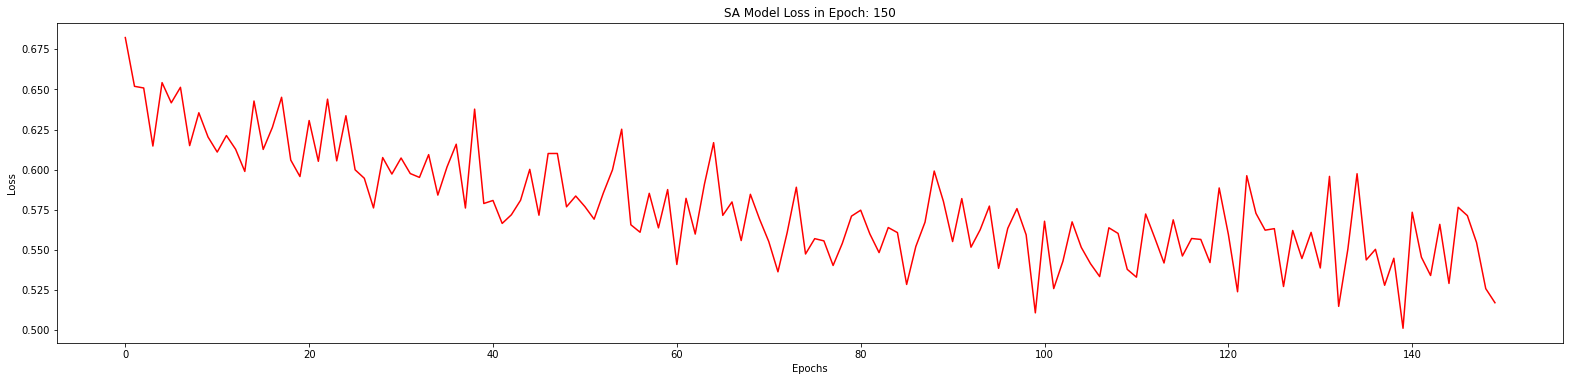

Epoch: 151, SA Model Loss: 0.5439
Epoch: 152, SA Model Loss: 0.5131
Epoch: 153, SA Model Loss: 0.5499
Epoch: 154, SA Model Loss: 0.5611
Epoch: 155, SA Model Loss: 0.5427
Epoch: 156, SA Model Loss: 0.5628
Epoch: 157, SA Model Loss: 0.5287
Epoch: 158, SA Model Loss: 0.5128
Epoch: 159, SA Model Loss: 0.5670
Epoch: 160, SA Model Loss: 0.6062
Epoch: 161, SA Model Loss: 0.5384
Epoch: 162, SA Model Loss: 0.5256
Epoch: 163, SA Model Loss: 0.5537
Epoch: 164, SA Model Loss: 0.5924
Epoch: 165, SA Model Loss: 0.5764
Epoch: 166, SA Model Loss: 0.5254
Epoch: 167, SA Model Loss: 0.5440
Epoch: 168, SA Model Loss: 0.5122
Epoch: 169, SA Model Loss: 0.5769
Epoch: 170, SA Model Loss: 0.5507
Epoch: 171, SA Model Loss: 0.5561
Epoch: 172, SA Model Loss: 0.5197
Epoch: 173, SA Model Loss: 0.5471
Epoch: 174, SA Model Loss: 0.5162
Epoch: 175, SA Model Loss: 0.5800
Epoch: 176, SA Model Loss: 0.5954
Epoch: 177, SA Model Loss: 0.5447
Epoch: 178, SA Model Loss: 0.5321
Epoch: 179, SA Model Loss: 0.5651
Epoch: 180, SA

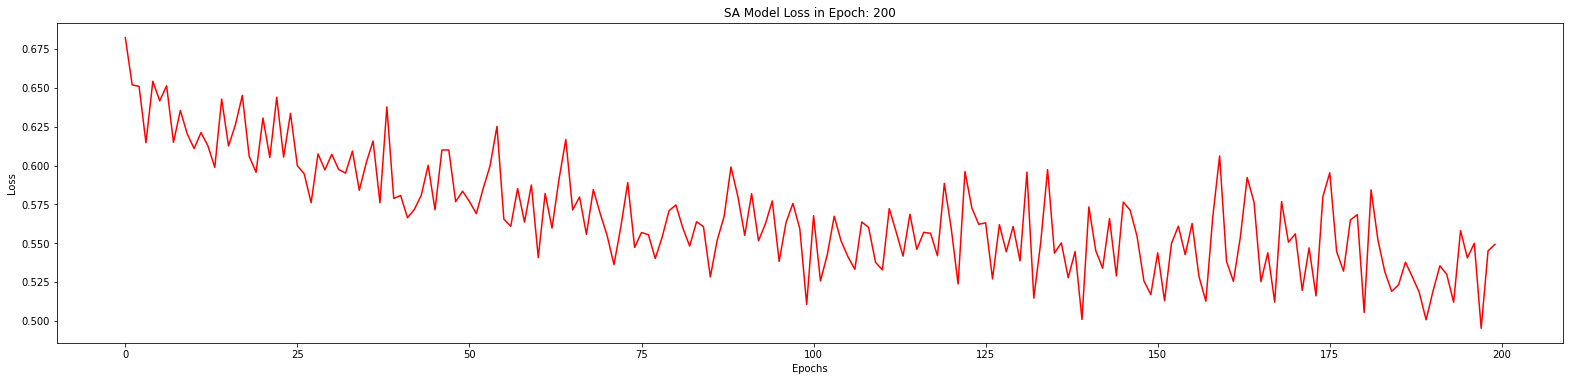

In [17]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [18]:
def SA_test(test_loader):
  SA_model_GCN.eval()
  correct = 0
  for batched_data in test_loader:  
    SA_test_out = SA_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)  
    SA_test_pred = SA_test_out.argmax(dim=1)  
    correct += int((SA_test_pred == batched_data.y).sum())  
  return correct / len(test_loader.dataset)  

In [19]:
SA_test_acc = SA_test(test_loader)
print(f'Test Accuracy: {SA_test_acc:.4f}')

Test Accuracy: 0.7368


# **Gradients of SA old way**

In [ ]:
def accumulate_gradients(model_for_you):
  before_SA = []
  after_SA = []
  
  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())
    if name == "conv1.lin.weight":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())

    if name == "conv2.bias":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())
    if name == "conv2.lin.weight":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())

    if name == "conv3.bias":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())
    if name == "conv3.lin.weight":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())

    if name == "lin.weight":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())
    if name == "lin.bias":
      before_SA.append(param.grad.detach().tolist())
      param.grad = torch.square(param.grad)
      after_SA.append(param.grad.detach().tolist())
  

  return before_SA, after_SA

In [ ]:
holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(SA_model_GCN)

In [ ]:
print(np.shape(holder_of_new_gradients[1]))
print(np.shape(square_grads_wrt_graph_label))
print(np.shape(test_dataset[0].x))

NameError: ignored

In [ ]:
for name, param in SA_model_GCN.named_parameters():
  print(name)

conv1.bias
conv1.lin.weight
conv2.bias
conv2.lin.weight
conv3.bias
conv3.lin.weight
lin.weight
lin.bias


In [ ]:
print(len(holder_of_old_gradients))
print(len(holder_of_old_gradients[6]))
print(holder_of_old_gradients[6])
print(holder_of_old_gradients[7])

8
2
[[0.0010444223880767822, 0.024098075926303864, 0.02370644547045231, -0.022749999538064003, 0.013384955935180187, -0.005045591853559017, -0.03951691836118698], [-0.0010444223880767822, -0.024098075926303864, -0.02370644360780716, 0.0227500032633543, -0.013384956866502762, 0.005045592784881592, 0.03951692581176758]]
[-0.014370352029800415, 0.014370355755090714]


In [ ]:
def accumulate_weights(model_for_you):
  before_SA = []
  after_SA = []
  StateDict = model_for_you.state_dict()    # STATE DICT is for Weights and Biases

  Conv1_biases = StateDict.get('conv1.bias')
  Conv1_Weights = StateDict.get('conv1.lin.weight')

  Conv2_biases = StateDict.get('conv2.bias')
  Conv2_Weights = StateDict.get('conv2.lin.weight')

  Conv3_biases = StateDict.get('conv3.bias')
  Conv3_Weights = StateDict.get('conv3.lin.weight')

  Dense_biases = StateDict.get('lin.bias')
  Dense_Weights = StateDict.get('lin.weight')
  
  before_SA.append(Conv1_biases.detach().tolist())
  Conv1_biases = torch.square(Conv1_biases)
  after_SA.append(Conv1_biases.detach().tolist())


  before_SA.append(Conv1_Weights.detach().tolist())
  Conv1_Weights = torch.square(Conv1_Weights)
  after_SA.append(Conv1_Weights.detach().tolist())


  before_SA.append(Conv2_biases.detach().tolist())
  Conv2_biases = torch.square(Conv2_biases)
  after_SA.append(Conv2_biases.detach().tolist())

  before_SA.append(Conv2_Weights.detach().tolist())
  Conv2_Weights = torch.square(Conv2_Weights)
  after_SA.append(Conv2_Weights.detach().tolist())


  before_SA.append(Conv3_biases.detach().tolist())
  Conv3_biases = torch.square(Conv3_biases)
  after_SA.append(Conv3_biases.detach().tolist())

  before_SA.append(Conv3_Weights.detach().tolist())
  Conv3_Weights = torch.square(Conv3_Weights)
  after_SA.append(Conv3_Weights.detach().tolist())


  before_SA.append(Dense_biases.detach().tolist())
  Dense_biases = torch.square(Dense_biases)
  after_SA.append(Dense_biases.detach().tolist())

  before_SA.append(Dense_Weights.detach().tolist())
  Dense_Weights = torch.square(Dense_Weights)
  after_SA.append(Dense_Weights.detach().tolist())
  

  return before_SA, after_SA

In [ ]:
holder_of_old_weights, holder_of_new_weights = accumulate_weights(SA_model_GCN)

In [ ]:
print(len(holder_of_old_weights[7]))
print(holder_of_old_weights[7])

2
[[-0.009932374581694603, 0.27527955174446106, -0.5595436096191406, 0.5777831673622131, 0.33545270562171936, -0.5036705136299133, 0.03947649896144867], [0.5142185091972351, -0.28258493542671204, 0.5496687293052673, -0.45988816022872925, -0.3799608051776886, 0.19227394461631775, 0.6062339544296265]]


# **SA**
# **Based on the Training Phase, for each of the Hidden Nodes in the hidden Layers, which Gradient is more important?**

In [ ]:
def SA_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, epoch): 
  layer = 1
  for i in range(len(holder_of_new_gradients[layer])):
    fig1 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA. Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer][i], color='r')
    ax2.plot(holder_of_old_gradients[layer][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
  
  layer = 2
  for i in range(len(holder_of_new_gradients[layer+1])):
    fig2 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA. Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+1][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+1][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
  
  layer = 3
  for i in range(len(holder_of_new_gradients[layer+2])):
    fig3 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA. Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+2][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+2][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

  layer = 4
  for i in range(len(holder_of_new_gradients[layer+3])):
    fig4 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA. Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+3][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+3][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

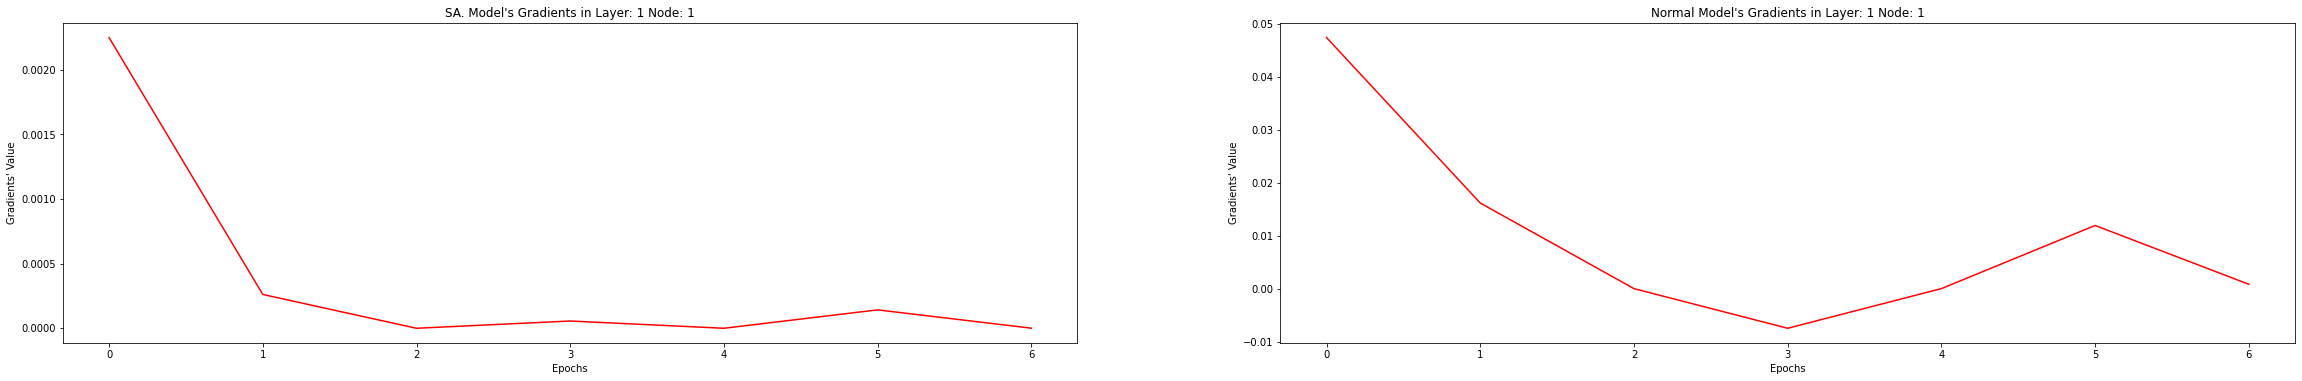

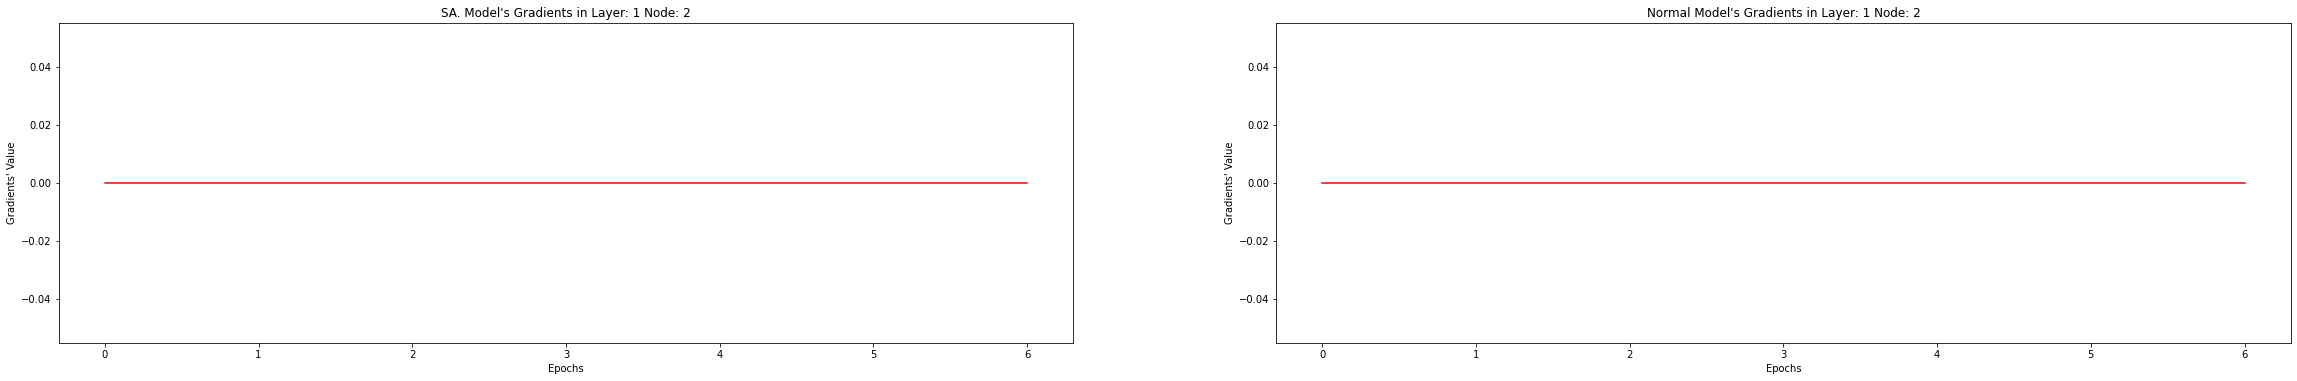

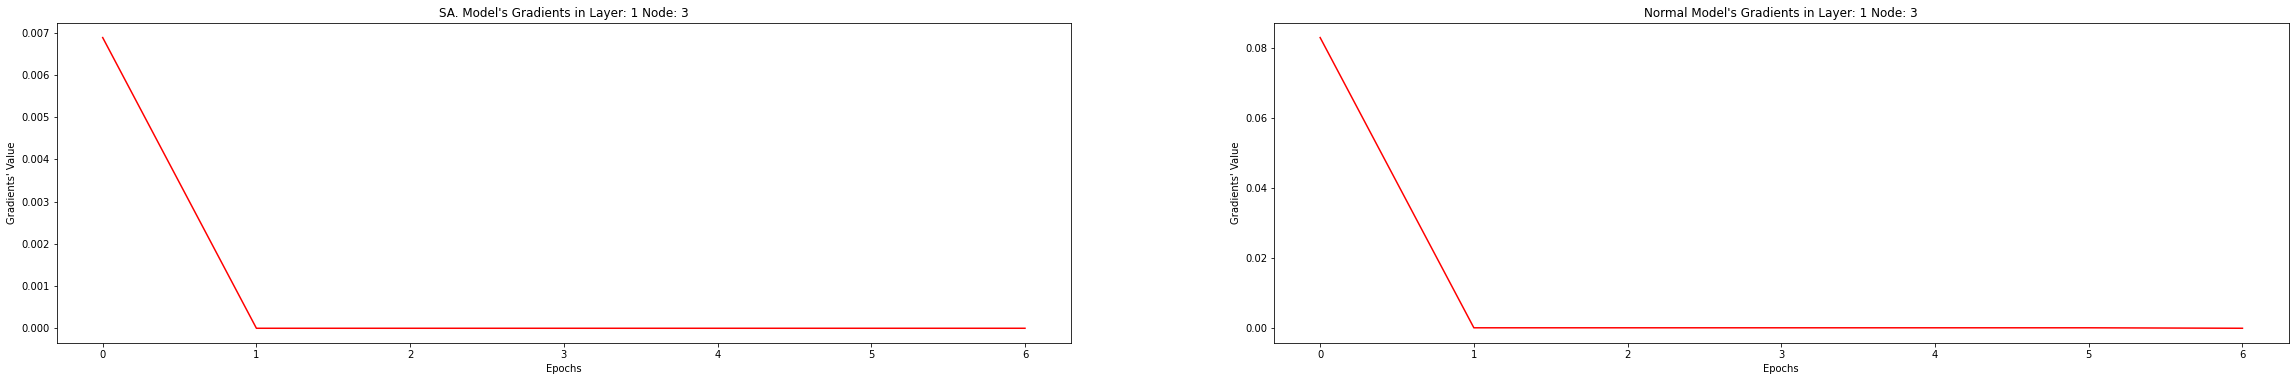

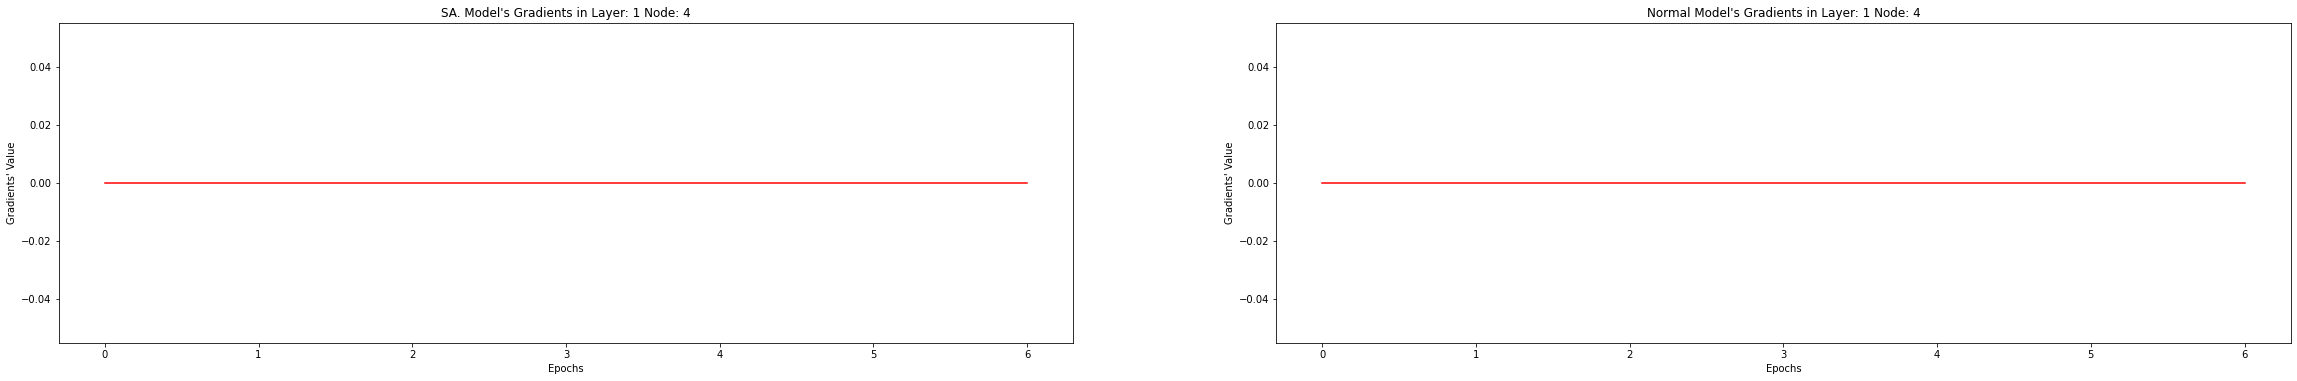

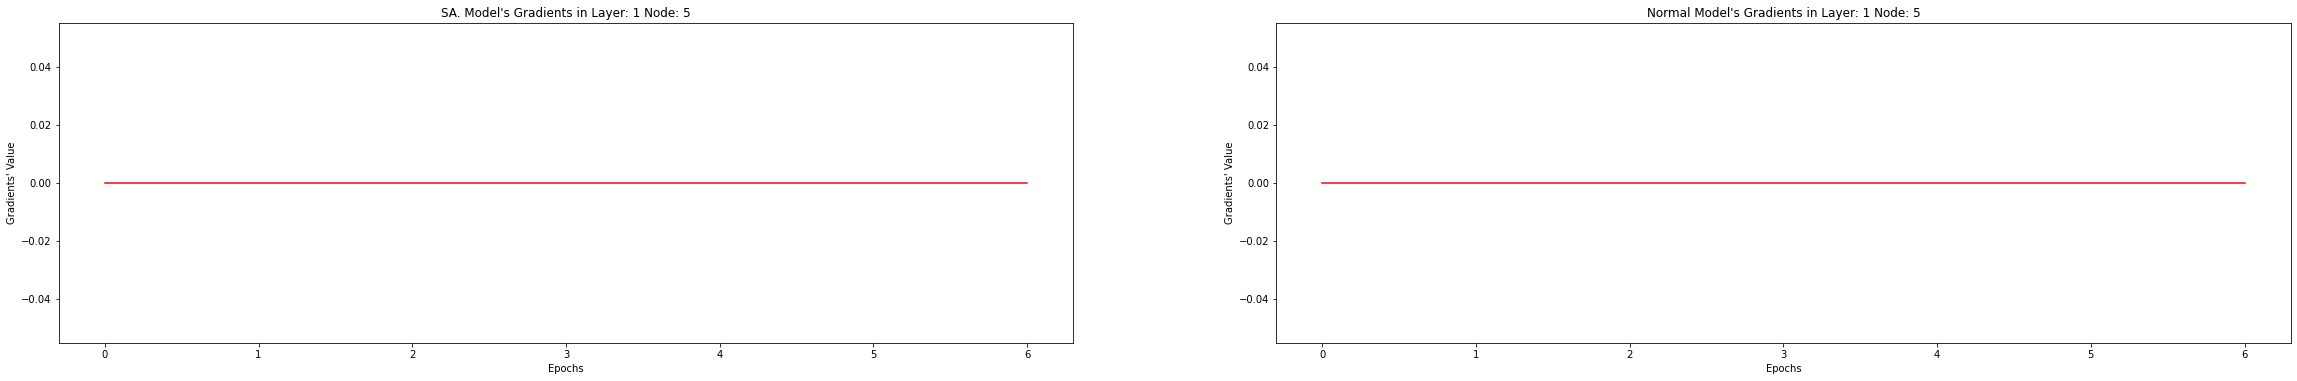

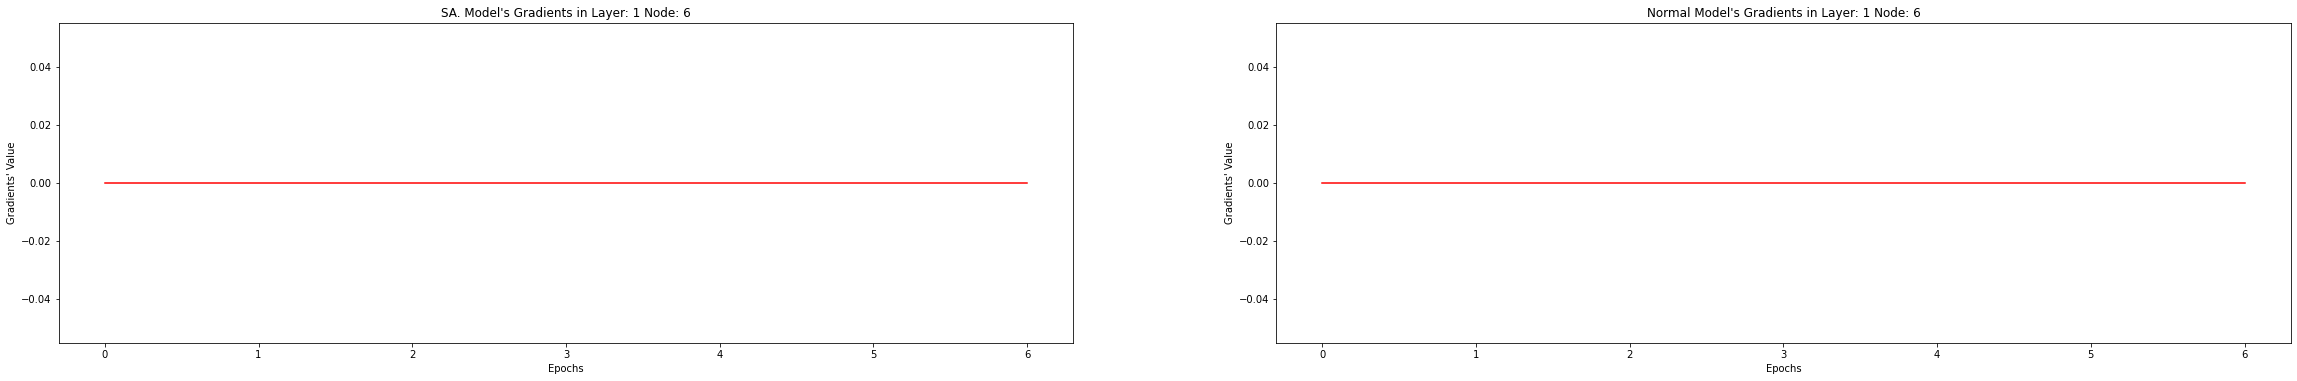

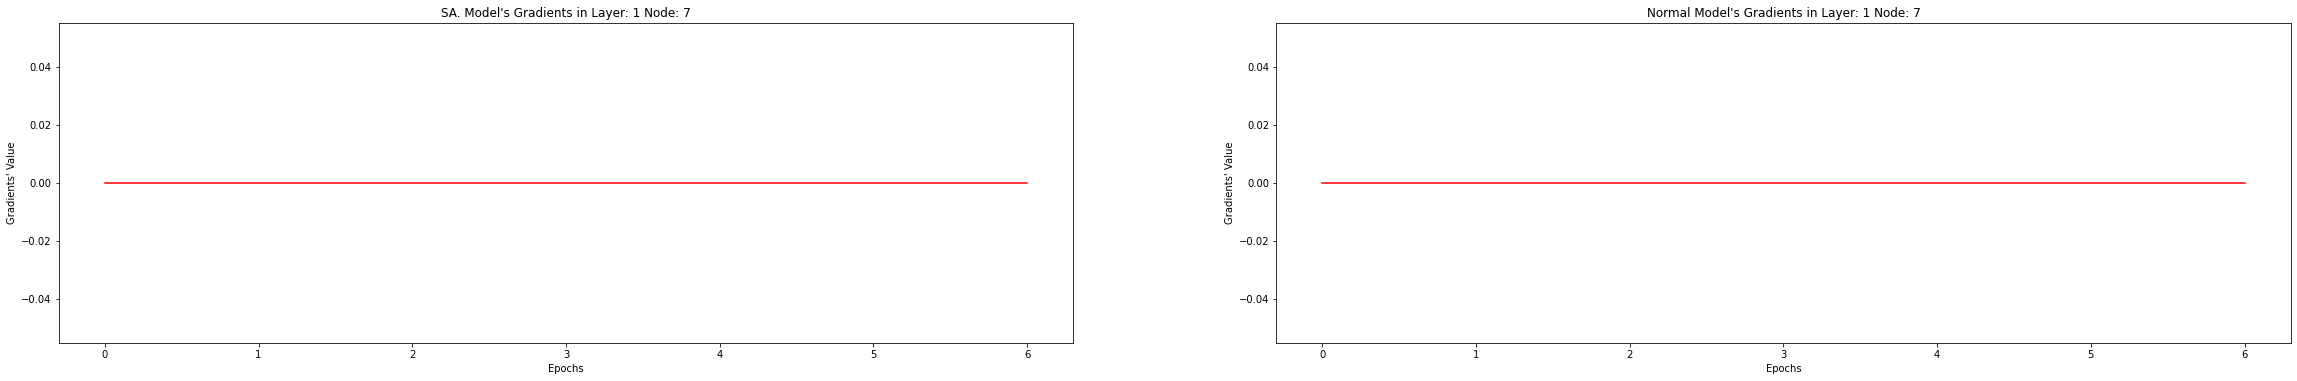

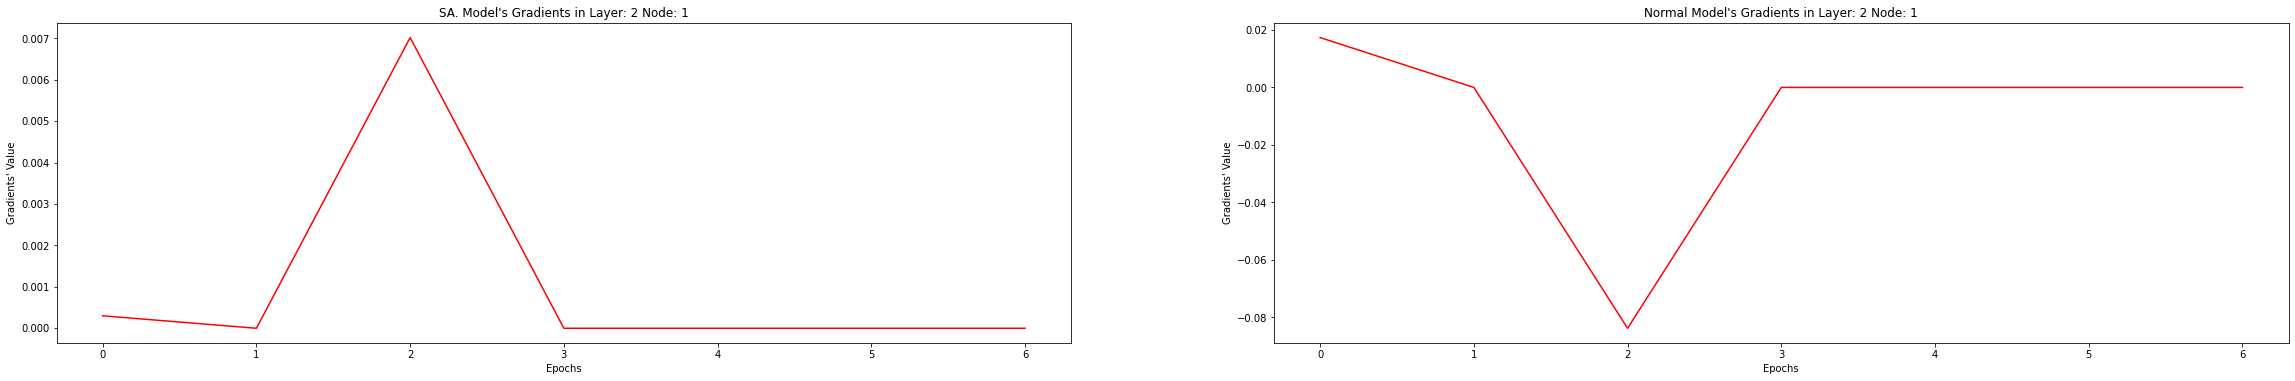

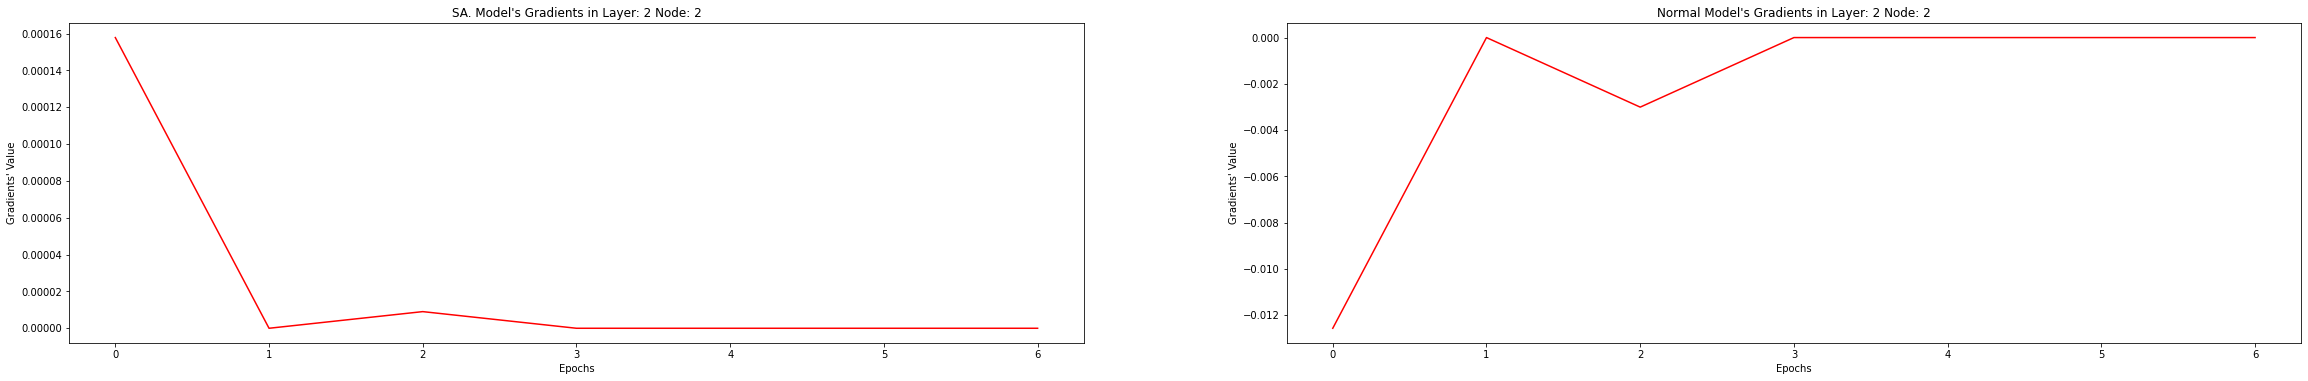

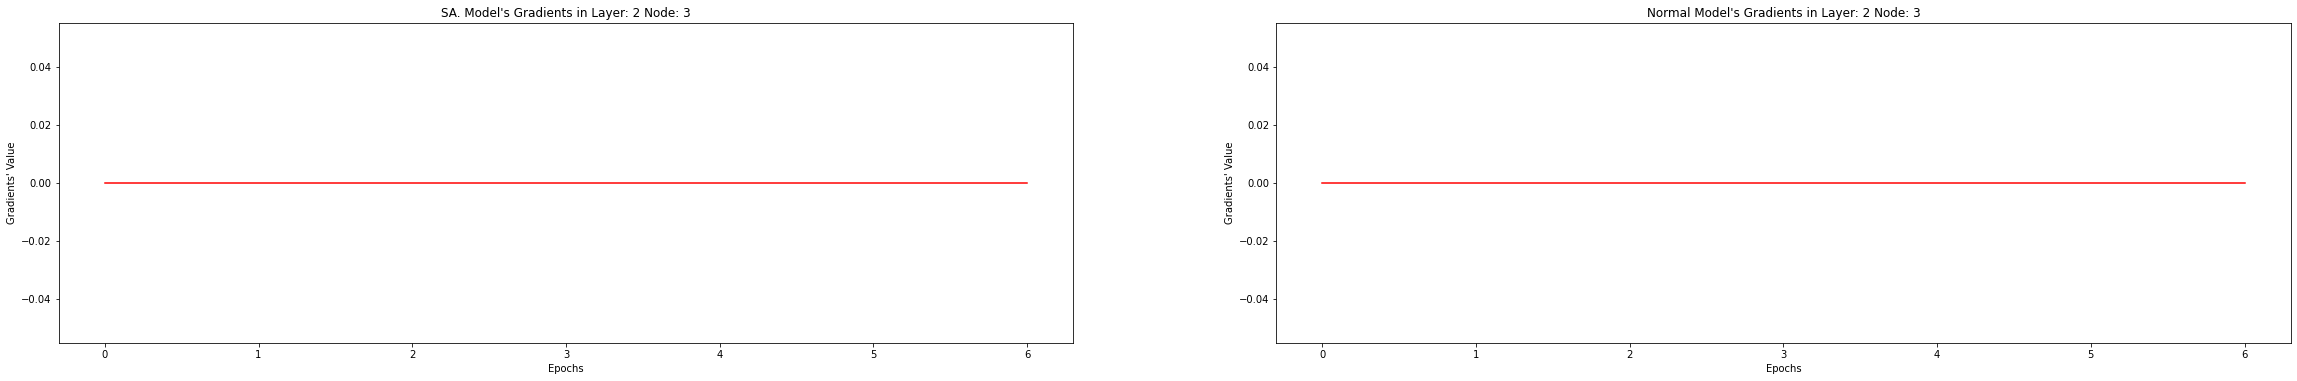

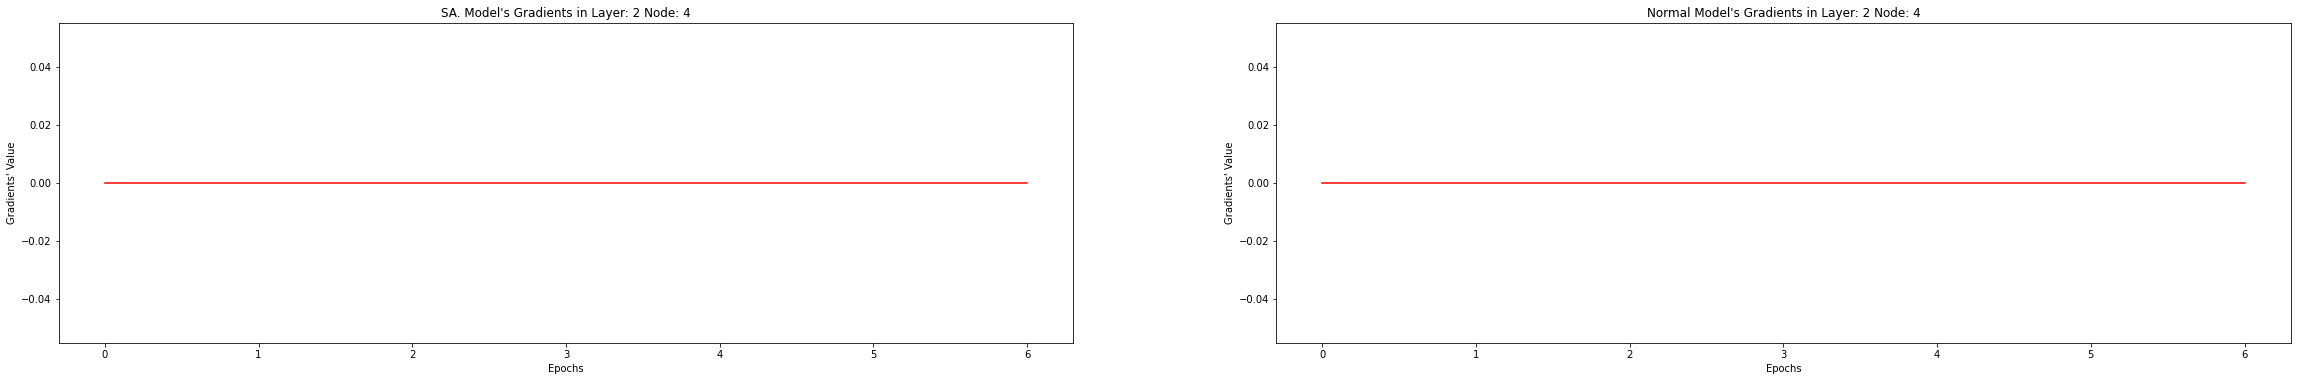

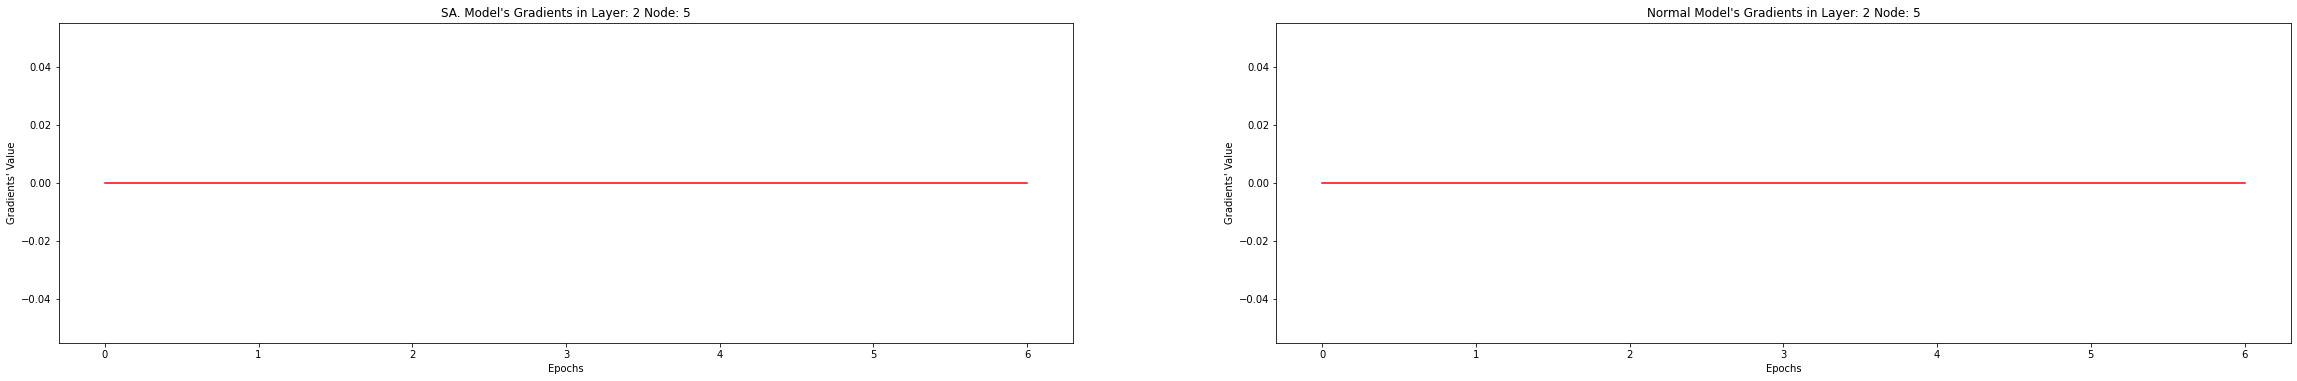

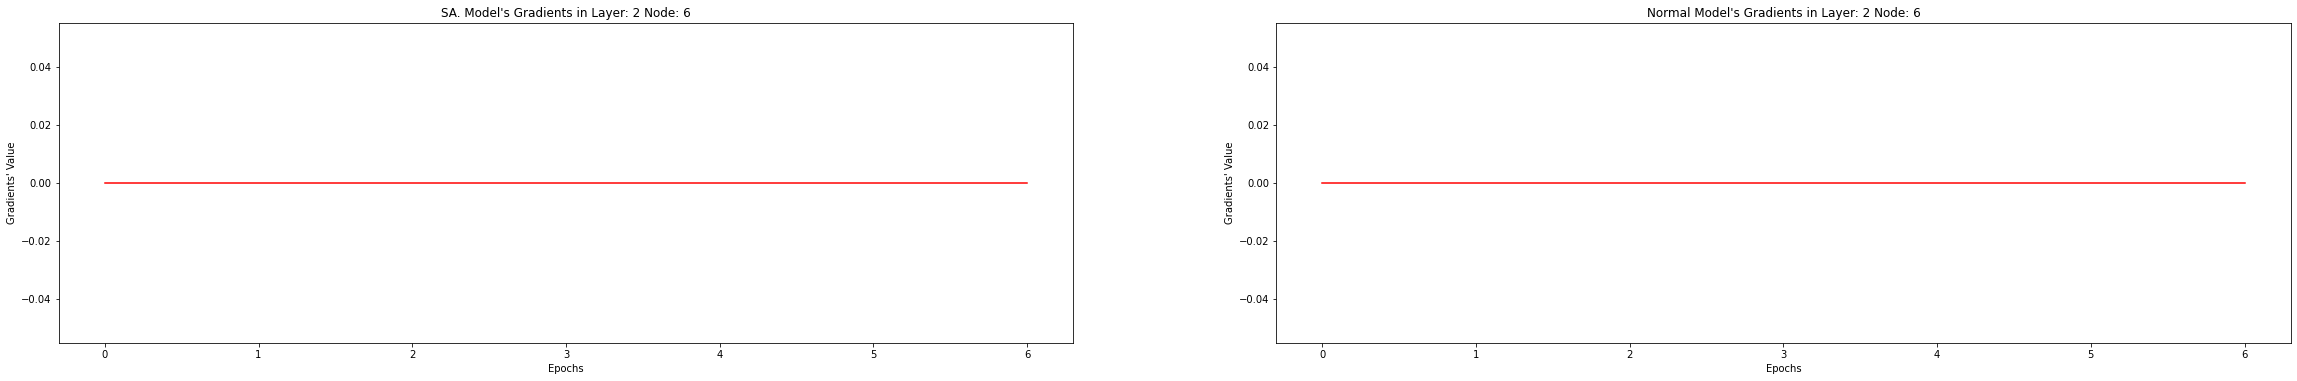

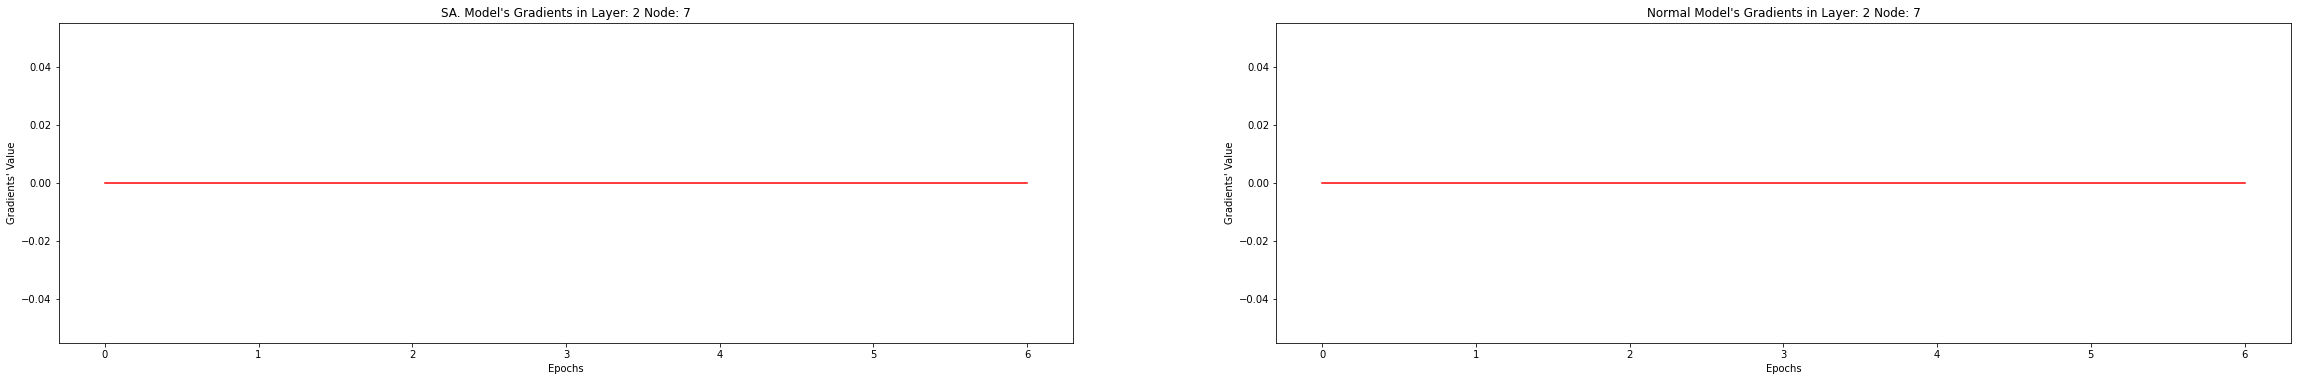

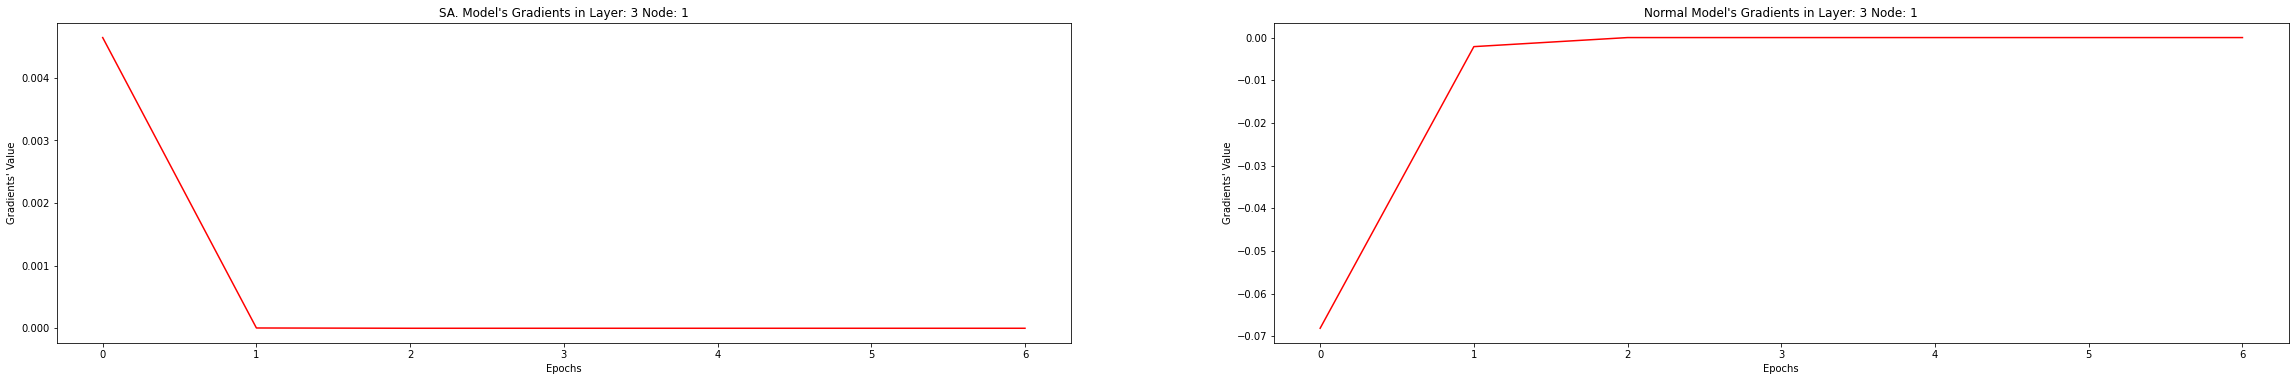

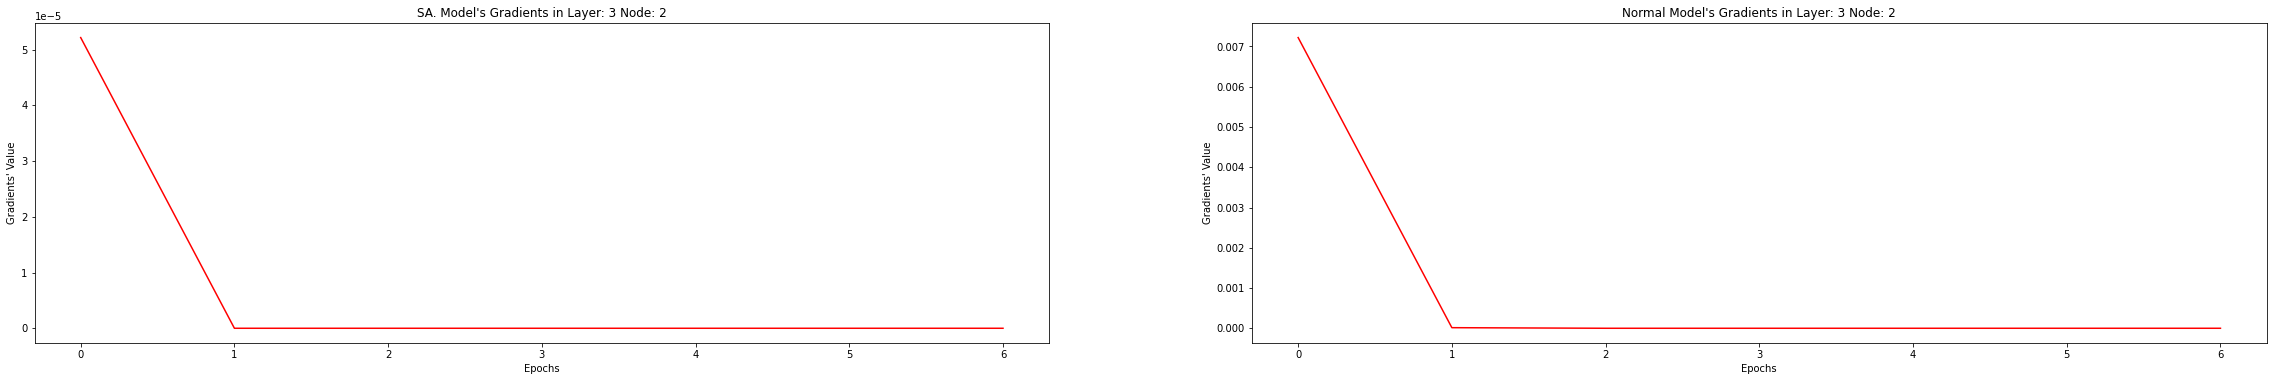

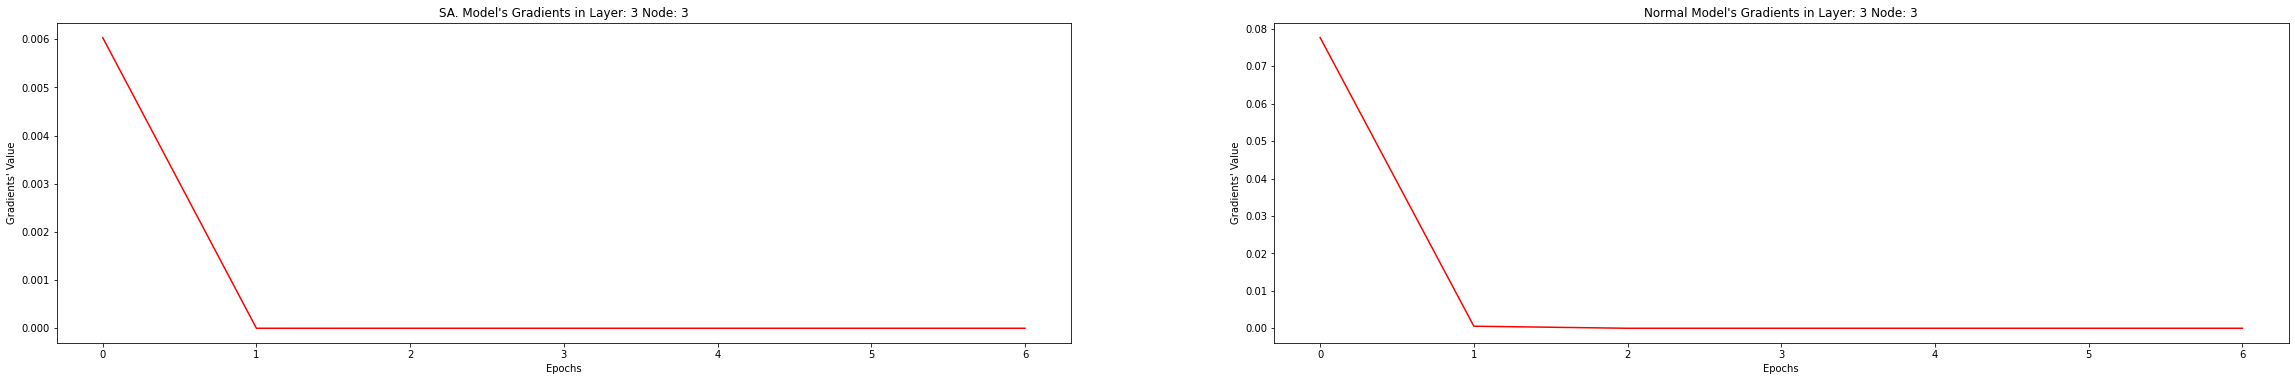

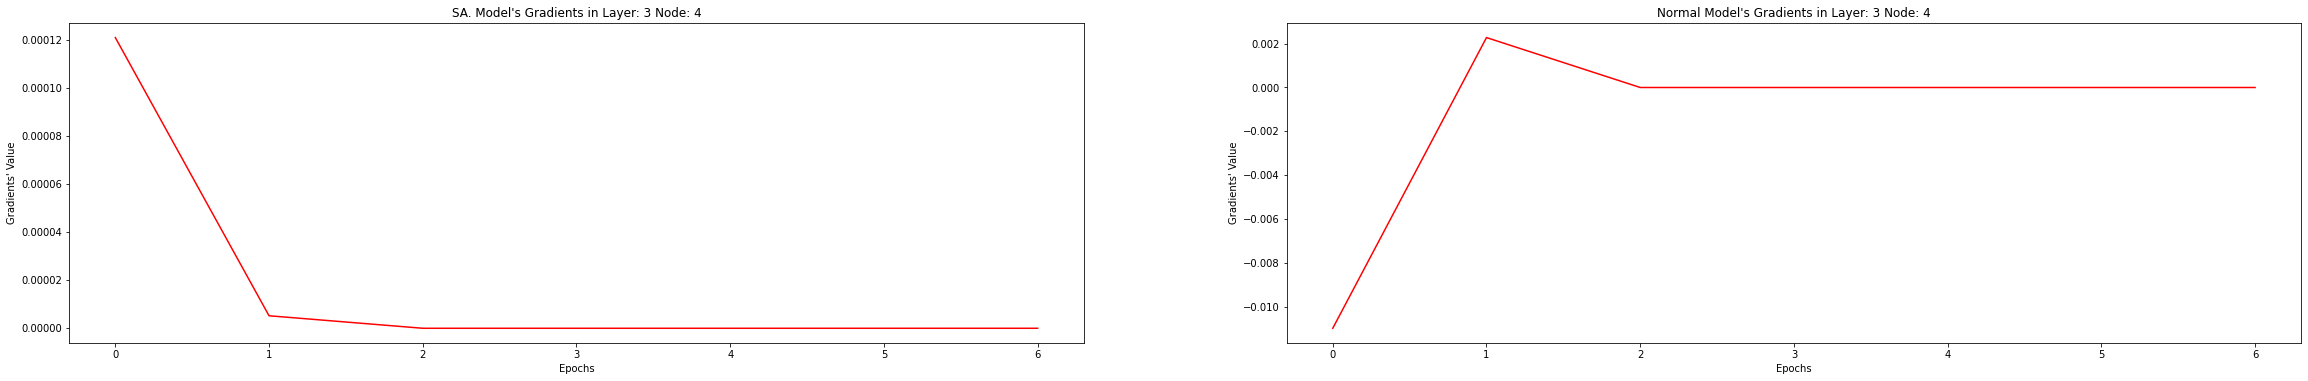

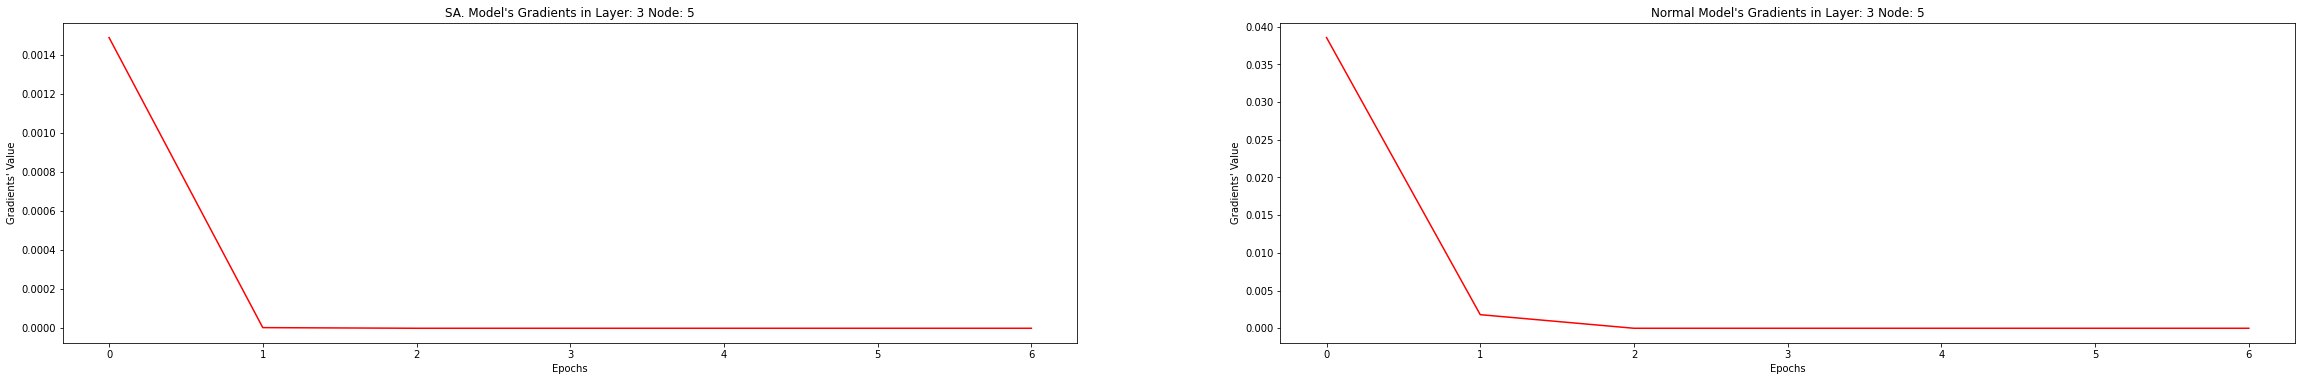

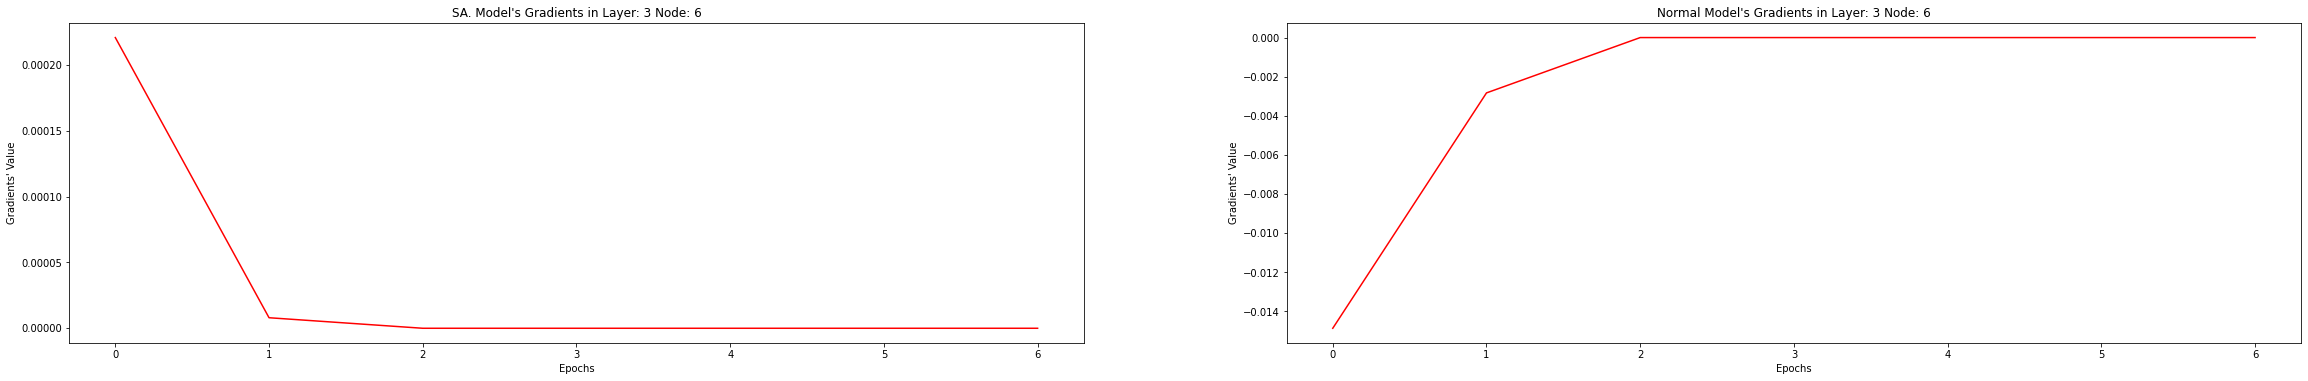

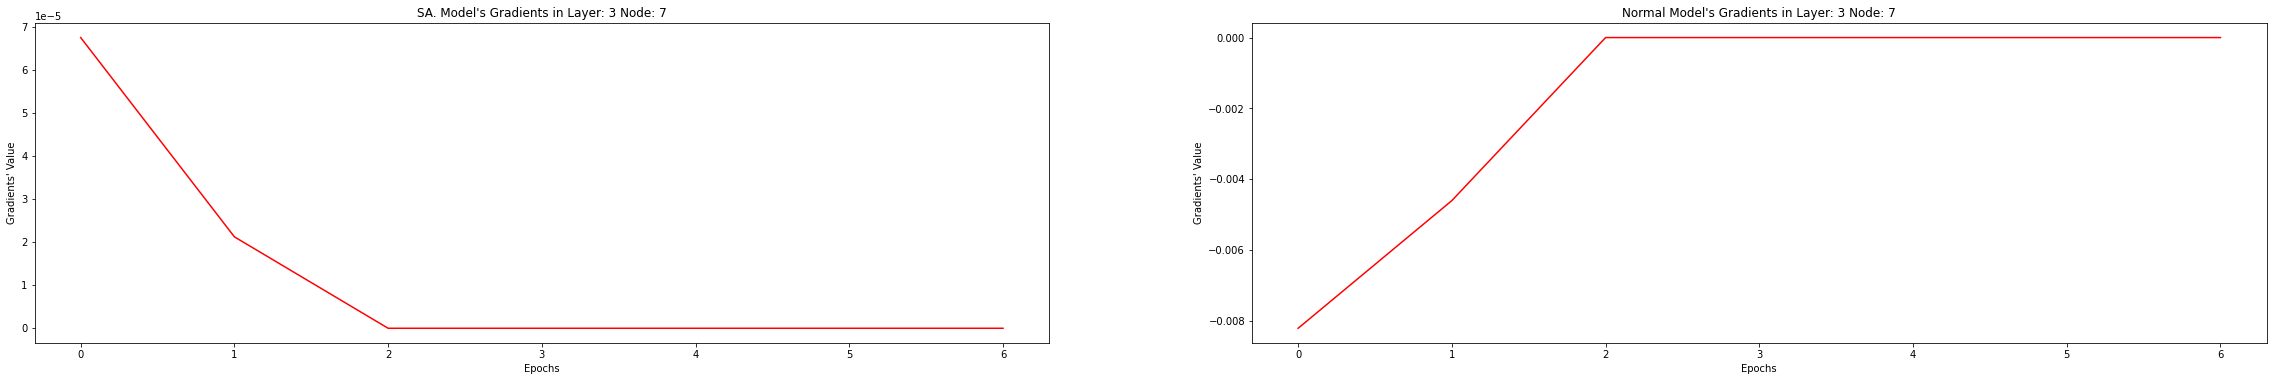

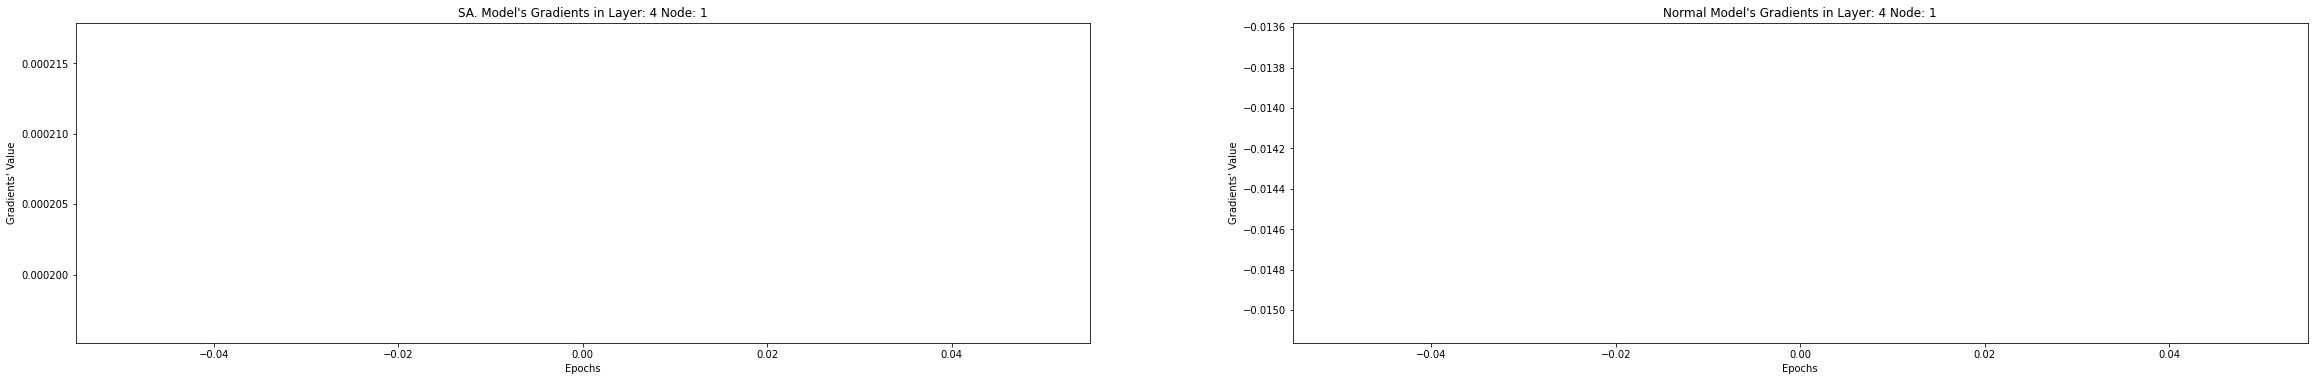

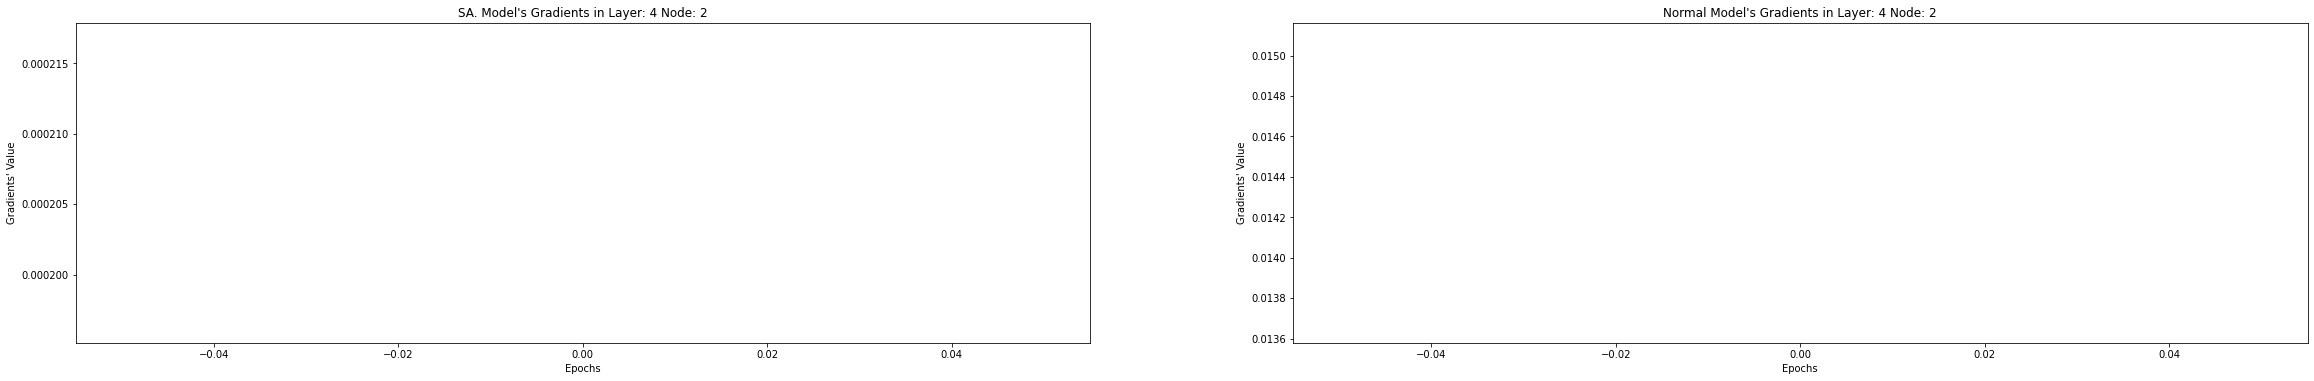

In [ ]:
SA_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, EPOCHS)

In [ ]:
print(SA_model_GCN.conv1)
sd = SA_model_GCN.state_dict()
print(sd.keys())
whole_weights = sd.items()
#print(whole_weights)

GCNConv(7, 7)
odict_keys(['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight', 'lin.weight', 'lin.bias'])


In [ ]:
'''def train_step():
  before_square = []
  after_square = []
  SA_loss_batch = []


  SA_model_GCN.train()
  SA_optimizer.zero_grad()
  for batched_data in train_loader:
    SA_out = SA_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    SA_loss = loss_calculations(SA_out, batched_data.y)
    SA_loss_batch.append(SA_loss)
    SA_loss.backward()
    SA_optimizer.step()

    batched_before_square = []
    batched_after_square = []

    for name, param in SA_model_GCN.named_parameters():

      if name == "conv1.bias":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())
      if name == "conv1.lin.weight":
        #print(param.grad.detach().clone())
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())

      if name == "conv2.bias":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())
      if name == "conv2.lin.weight":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())

      if name == "conv3.bias":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())
      if name == "conv3.lin.weight":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())

      if name == "lin.bias":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())
      if name == "lin.weight":
        batched_before_square.append(param.grad.detach().clone())
        param.grad = torch.square(param.grad)
        batched_after_square.append(param.grad.detach().clone())
        
    before_square.append(batched_before_square)
    after_square.append(batched_after_square)
  #print(len(before_square[-1]))
    
  non_SA_backpropagation_SAME_MODEL(before_square)  
  SA_backpropagation_SAME_MODEL(after_square)

  SA_optimizer.step()
  
  #############################################################

  non_SA_model_GCN.train()
  for data in train_loader:
    non_SA_out = non_SA_model_GCN(data.x, data.edge_index, data.batch)
    non_SA_loss = loss_calculations(non_SA_out, data.y)
    non_SA_loss_batch.append(non_SA_loss)
    non_SA_loss.backward()
    non_SA_optimizer.step()
    non_SA_optimizer.zero_grad()
  


  return torch.mean(torch.tensor(SA_loss_batch)), torch.mean(torch.tensor(non_SA_loss_batch))
'''

'def train_step():\n  before_square = []\n  after_square = []\n  SA_loss_batch = []\n\n\n  SA_model_GCN.train()\n  SA_optimizer.zero_grad()\n  for batched_data in train_loader:\n    SA_out = SA_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)\n    SA_loss = loss_calculations(SA_out, batched_data.y)\n    SA_loss_batch.append(SA_loss)\n    SA_loss.backward()\n    SA_optimizer.step()\n\n    batched_before_square = []\n    batched_after_square = []\n\n    for name, param in SA_model_GCN.named_parameters():\n\n      if name == "conv1.bias":\n        batched_before_square.append(param.grad.detach().clone())\n        param.grad = torch.square(param.grad)\n        batched_after_square.append(param.grad.detach().clone())\n      if name == "conv1.lin.weight":\n        #print(param.grad.detach().clone())\n        batched_before_square.append(param.grad.detach().clone())\n        param.grad = torch.square(param.grad)\n        batched_after_square.append(param.grad.detach().cl

In [ ]:
print(holder_of_new_gradients[1])
print(test_dataset[0].x)

[[0.0022492827847599983, 0.0002615263219922781, 0.0, 5.6101260270224884e-05, 0.0, 0.00014226508210413158, 6.721147087773716e-07], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.006882885936647654, 0.0, 0.0, 0.0, 0.0, 0.0, 1.83770971773356e-08], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
      

# **Gradients of Test Samples with respect to each class**

In [20]:
def compute_grad(model, graph, with_respect):
  prediction = model(graph.x, graph.edge_index, graph.batch)
  if with_respect == 1 :
    loss = loss_calculations(prediction, graph.y)
    #print(loss)
  elif with_respect == 2:
    loss = loss_calculations(prediction, torch.tensor([0]))
    #print(loss)  
  elif with_respect == 3:
    loss = loss_calculations(prediction, torch.tensor([1]))
    #print(loss)
  return torch.autograd.grad(loss, list(model.parameters()))

In [21]:
def compute_sample_grads(model, test_dataset, with_respect):

  sample_grads = [compute_grad(model, graph, with_respect) for graph in test_dataset]
  sample_grads = zip(*sample_grads)
  sample_grads = [torch.stack(shards) for shards in sample_grads]
  return sample_grads

In [22]:
per_sample_grads_wrt_graph_label = compute_sample_grads(SA_model_GCN, test_dataset, 1)
per_sample_grads_wrt_class_zero = compute_sample_grads(SA_model_GCN, test_dataset, 2)
per_sample_grads_wrt_class_one = compute_sample_grads(SA_model_GCN, test_dataset, 3)

In [23]:
grads_wrt_graph_label = per_sample_grads_wrt_graph_label[1].detach().tolist()
grads_wrt_class_zero = per_sample_grads_wrt_class_zero[1].detach().tolist()
grads_wrt_class_one = per_sample_grads_wrt_class_one[1].detach().tolist()

In [24]:
#print(per_sample_grads_wrt_graph_label, per_sample_grads_wrt_class_zero, per_sample_grads_wrt_class_one)
#print(per_sample_grads_wrt_graph_label[1])
print(np.shape(grads_wrt_graph_label[1]), np.shape(grads_wrt_class_zero[0]), np.shape(grads_wrt_class_one[0]))

(7, 7) (7, 7) (7, 7)


In [25]:
def compute_square_gradients(your_model, dataset):
  per_sample_grads_wrt_graph_label = compute_sample_grads(your_model, dataset, 1)
  per_sample_grads_wrt_class_zero = compute_sample_grads(your_model, dataset, 2)
  per_sample_grads_wrt_class_one = compute_sample_grads(your_model, dataset, 3)

  grads_wrt_graph_label = per_sample_grads_wrt_graph_label[1].detach().tolist()
  square_grads_wrt_graph_label = torch.square(per_sample_grads_wrt_graph_label[1])
  square_grads_wrt_graph_label = square_grads_wrt_graph_label.detach().tolist()

  grads_wrt_class_zero = per_sample_grads_wrt_class_zero[1].detach().tolist()
  square_grads_wrt_class_zero = torch.square(per_sample_grads_wrt_class_zero[1])
  square_grads_wrt_class_zero = square_grads_wrt_class_zero.detach().tolist()

  grads_wrt_class_one = per_sample_grads_wrt_class_one[1].detach().tolist()
  square_grads_wrt_class_one = torch.square(per_sample_grads_wrt_class_one[1])
  square_grads_wrt_class_one = square_grads_wrt_class_one.detach().tolist()

  return square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one

In [26]:
square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one = compute_square_gradients(SA_model_GCN, test_dataset)

In [ ]:
#grads_wrt_graph_label = per_sample_grads_wrt_graph_label[1].detach().tolist()
#square_grads_wrt_graph_label = torch.square(per_sample_grads_wrt_graph_label[1])
#square_grads_wrt_graph_label = square_grads_wrt_graph_label.detach().tolist()

#grads_wrt_class_zero = per_sample_grads_wrt_class_zero[1].detach().tolist()
#square_grads_wrt_class_zero = torch.square(per_sample_grads_wrt_class_zero[1])
#square_grads_wrt_class_zero = square_grads_wrt_class_zero.detach().tolist()

#grads_wrt_class_one = per_sample_grads_wrt_class_one[1].detach().tolist()
#square_grads_wrt_class_one = torch.square(per_sample_grads_wrt_class_one[1])
#square_grads_wrt_class_one = square_grads_wrt_class_one.detach().tolist()

In [27]:
print(np.shape(square_grads_wrt_graph_label))
print(np.shape(square_grads_wrt_class_zero))
print(np.shape(square_grads_wrt_class_one))

(38, 7, 7)
(38, 7, 7)
(38, 7, 7)


In [28]:
for i in range(len(square_grads_wrt_graph_label)):
  print("Graph Label: ", square_grads_wrt_graph_label[i], "Zero: ", square_grads_wrt_class_zero[i], "One: ", square_grads_wrt_class_one[i])

Graph Label:  [[0.08838602155447006, 0.0010241805575788021, 0.001858543255366385, 0.0, 0.0, 0.0, 0.0], [0.03829888254404068, 0.00013668430619873106, 0.00021273332822602242, 0.0, 0.0, 0.0, 0.0], [0.014089544303715229, 0.00010172844486078247, 0.00019067790708504617, 0.0, 0.0, 0.0, 0.0], [0.1110134869813919, 0.0006856133695691824, 0.0013095977483317256, 0.0, 0.0, 0.0, 0.0], [0.05354687571525574, 0.0003033702087122947, 0.0005019871168769896, 0.0, 0.0, 0.0, 0.0], [0.17938105762004852, 0.0007644237484782934, 0.0014316035667434335, 0.0, 0.0, 0.0, 0.0], [0.02507566288113594, 0.00012800893455278128, 0.00023162754951044917, 0.0, 0.0, 0.0, 0.0]] Zero:  [[2.090299606323242, 0.024221530184149742, 0.043953925371170044, 0.0, 0.0, 0.0, 0.0], [0.9057555198669434, 0.003232537768781185, 0.005031070671975613, 0.0, 0.0, 0.0, 0.0], [0.3332129418849945, 0.0024058425333350897, 0.004509467165917158, 0.0, 0.0, 0.0, 0.0], [2.6254310607910156, 0.0162145234644413, 0.03097154200077057, 0.0, 0.0, 0.0, 0.0], [1.26636

## **Calculate Fiedelity**

In [29]:

def Compute_ROC_AUC(your_model, your_dataset):
  preds = []
  reals = []
  #print(len(your_dataset))
  num_classes = 2
  
  if num_classes > 2:
    print("Fidelity is only for Binaryclassification")
    return 0
    
  your_model.eval()
  for batched_data in your_dataset:
    SA_test_out = your_model(batched_data.x, batched_data.edge_index, batched_data.batch)
    logits = F.log_softmax(SA_test_out, dim=1)
    prob = F.softmax(logits, dim=1)
    
    preds.append(prob.cpu().detach())
    
  for i in range(len(your_dataset)):
    reals.append(your_dataset[i].y.cpu().detach().tolist())  
  preds = torch.cat(preds).cpu().numpy()
  preds = preds[:, 1]

  
  roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
  return roc_auc
  
  #return preds, reals

In [30]:

auc_roc = Compute_ROC_AUC(SA_model_GCN, test_dataset)
print(auc_roc)


0.76


In [31]:
input = torch.randn(1, 10, requires_grad=True)
print(input)
torch.sum(input, dim=1).tolist()

tensor([[ 1.4494e-01, -3.8231e-01,  2.0986e+00,  1.4111e+00, -6.5507e-04,
         -8.5482e-01, -6.5802e-02,  5.4782e-01,  1.0020e+00, -4.1564e-01]],
       requires_grad=True)


[3.4851269721984863]

In [32]:
def saliency(dataset, gradients):
  Final= []
  for i in range(len(dataset)):
    Mid = []
    for node in dataset[i].x.detach().numpy():
      First = []
      for grad_list in gradients[i]:
        First.append(np.multiply(node, grad_list))
      Mid.append(First)
    Final.append(Mid)
  
  Saliency_Nodes = []
  for graph in Final:
    Node = []
    for node in graph:
      Grad = []
      for grad in node:
        Grad.append(sum(grad))
      Node.append(sum(Grad))
    #norm = [(float(i)-min(Node))/(max(Node)-min(Node)) for i in Node]
    norm = [(float(i))/(max(Node) + 1e-16) for i in Node]
    Saliency_Nodes.append(norm)
  return Saliency_Nodes

In [33]:
start_generation = perf_counter()
Sal = saliency(test_dataset, square_grads_wrt_graph_label)
time_consumption = perf_counter() - start_generation

In [34]:
def saliency_time(dataset, grds):
  start_generation = perf_counter()
  Sal = saliency(dataset, square_grads_wrt_graph_label)
  time_consumption = perf_counter() - start_generation
  return time_consumption

In [35]:
print(saliency_time(test_dataset, square_grads_wrt_graph_label))

0.02805880799996885


In [36]:
print(time_consumption)
print(len(Sal))
print(len(Sal[0]))
print(Sal[0][0])

0.03450949799997716
38
28
0.9999999999999998


In [37]:
print(len(Sal))
print(len(Sal[0]))
print(Sal[1])

38
28
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06801663871980289, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06801663871980289, 0.02600186592650929, 0.02600186592650929, 0.02600186592650929, 0.005055062032408158, 0.06801663871980289, 0.06801663871980289]


In [38]:
def is_salient(score, importance_range):
	start, end = importance_range
	if start <= score <= end:
		return True
	else:
		return False

In [39]:
def drop_important_nodes(your_dataset, importance_range, grads_first_layer):
  SA_attribution_scores = saliency(your_dataset, grads_first_layer)
  occluded_GNNgraph_list = []
  
  for i in range(len(SA_attribution_scores)):
    sample_graph = deepcopy(your_dataset[i])
    for j in range(len(sample_graph.x)):
      
      if is_salient((SA_attribution_scores[i][j]), importance_range):
        #print("before: ", sample_graph.x[j])
        sample_graph.x[j][:] = 0
        #print(torch.zeros_like(sample_graph.x[j]))
        #print("manipulated: ",sample_graph.x[j])
    occluded_GNNgraph_list.append(sample_graph)
  return occluded_GNNgraph_list

In [40]:
new_graph_dataset = drop_important_nodes(test_dataset, (0.5, 1), square_grads_wrt_graph_label)

In [41]:
print(new_graph_dataset)

[Data(edge_index=[2, 66], x=[28, 7], edge_attr=[66, 4], y=[1]), Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1]), Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1]), Data(edge_index=[2, 58], x=[25, 7], edge_attr=[58, 4], y=[1]), Data(edge_index=[2, 56], x=[26, 7], edge_attr=[56, 4], y=[1]), Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1]), Data(edge_index=[2, 32], x=[15, 7], edge_attr=[32, 4], y=[1]), Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1]), Data(edge_index=[2, 34], x=[15, 7], edge_attr=[34, 4], y=[1]), Data(edge_index=[2, 24], x=[12, 7], edge_attr=[24, 4], y=[1]), Data(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1]), Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1]), Data(edge_index=[2, 32], x=[15, 7], edge_attr=[32, 4], y=[1]), Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1]), Data(edge_index=[2, 50], x=[22, 7], edge_attr=[50, 4], y=[1]), Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4],

In [42]:
print(len(new_graph_dataset))
print(len(new_graph_dataset[0].x))
for i, j, a in zip(new_graph_dataset, test_dataset, Sal):
  for k, l, b in zip(i.x, j.x, a):
    print(k, l, "---->", b)

38
28
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tensor([0., 0., 0., 0., 0., 0., 0.]) tensor([1., 0., 0., 0., 0., 0., 0.]) ----> 0.9999999999999998
tens

In [43]:
for i in range(len(test_dataset[0].x)):
  print(test_dataset[0].x[i], "------", new_graph_dataset[0].x[i])

tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.]) ------ tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 

In [44]:
auc_roc1 = Compute_ROC_AUC(SA_model_GCN, test_dataset)
print(auc_roc1)

auc_roc2 = Compute_ROC_AUC(SA_model_GCN, new_graph_dataset)
print(auc_roc2)

0.76
0.7661538461538462


In [45]:
def Fidelity(your_model, your_dataset, grads_first_layer, importance_range):

  auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
  new_graph_dataset = drop_important_nodes(your_dataset, importance_range, grads_first_layer)
  auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

  return auc_roc_after_droping_important_nodes - auc_roc_before_droping_important_nodes

In [46]:
fid_square_glabel = Fidelity(SA_model_GCN, test_dataset, square_grads_wrt_graph_label, importance_range=(0.5, 1))
print(fid_square_glabel)
#fid_square_class0 = Fidelity(SA_model_GCN, test_dataset, square_grads_wrt_class_zero, importance_range=(0.5, 1))
#print(fid_square_class0)
#fid_square_class1 = Fidelity(SA_model_GCN, test_dataset, square_grads_wrt_class_one, importance_range=(0.5, 1))
#print(fid_square_class1)

#fid = Fidelity(SA_model_GCN, test_dataset, grads_wrt_graph_label, importance_range=(0.5, 1))
#print(fid)
#fid = Fidelity(SA_model_GCN, test_dataset, grads_wrt_class_zero, importance_range=(0.5, 1))
#print(fid)
#fid = Fidelity(SA_model_GCN, test_dataset, grads_wrt_class_one, importance_range=(0.5, 1))
#print(fid)

0.006153846153846176


## **Contrastivity**

In [47]:
def binarize_scores(your_dataset, grads_first_layer, importance_range):
  SA_attribution_scores = saliency(your_dataset, grads_first_layer)
  binarized_attribution_scores_list = []
  for scores in SA_attribution_scores:
    binary_score = ''
    for score in scores:
      if is_salient(abs(float(score)), importance_range):
        binary_score += '1'
      else:
        binary_score += '0'
    binarized_attribution_scores_list.append(binary_score)
  return binarized_attribution_scores_list

In [48]:
binarized_square_grads_graph = binarize_scores(test_dataset, square_grads_wrt_graph_label, importance_range=(0.5, 1))
binarized_square_grads_class_zero = binarize_scores(test_dataset, square_grads_wrt_class_zero, importance_range=(0.5, 1))
binarized_square_grads_class_one = binarize_scores(test_dataset, square_grads_wrt_class_one, importance_range=(0.5, 1))

In [49]:
print(binarized_square_grads_graph)
print(binarized_square_grads_class_zero)
print(binarized_square_grads_class_one)

['1111111111111111111111000000', '11111101111110000000', '1111111111111111000', '1111111111111111000111100', '11111110111111000000000000', '11111111111111111111000000', '101111110111000', '11111100000', '111111111111000', '110111111000', '11111111111111111111000', '1111111111111111000', '111111111111000', '11111100000', '1111111111111111000000', '1111110001111110', '11111111111111111111000', '11001111111111111000', '11111100011111110', '1111111000111111', '11101111000111110000000', '11111100000', '11111111111111111111000000', '1111111111111111000000', '1111110001111111000', '1111110000000', '1111110000000', '1111111100011000', '1111111111111111000000', '1111111111110000', '111101000011', '111111000111111000000', '1111111111111000111111100', '111111111111000000000', '11111111111111111111000', '111110011000', '1111111111000', '1111111111111111000']
['1111111111111111111111000000', '11111101111110000000', '1111111111111111000', '1111111111111111000111100', '11111110111111000000000000', '1

In [50]:
binarized_grads_graph = binarize_scores(test_dataset, grads_wrt_graph_label, importance_range=(0.5, 1))
binarized_grads_class_zero = binarize_scores(test_dataset, grads_wrt_class_zero, importance_range=(0.5, 1))
binarized_grads_class_one = binarize_scores(test_dataset, grads_wrt_class_one, importance_range=(0.5, 1))

In [51]:
print(binarized_grads_graph)
print(binarized_grads_class_zero)
print(binarized_grads_class_one)

['0000000000000000000000111111', '11111101111110000000', '0000000000000000111', '0000000000000000100000000', '00000001000000111111111111', '00000000000000000000111111', '101111110111000', '11111100000', '000000000000111', '110111111000', '00000000000000000000111', '0000000000000000111', '111111111111000', '11111100000', '0000000000000000111111', '1111110001111110', '00000000000000000000111', '00010000000000000100', '00000011100000000', '1111111000111111', '00000000011000000100100', '11111100000', '00000000000000000000111111', '0000000000000000111111', '0000001110000000111', '1111110000000', '0000001111111', '0000000011100111', '0000000000000000111111', '0000000000001111', '111101000011', '111111000111111000000', '0000000000000100000000000', '000000000000111111111', '00000000000000000000111', '000001100100', '1111111111000', '0000000000000000111']
['1111111111111111111111000000', '11111101111110000000', '1111111111111111000', '1111111111111111000111100', '11111110111111000000000000', '1

In [52]:
def compute_contrastivity(your_dataset, your_grads_class0, your_grads_class1, importance_range):
  binarized_salient_nodes_for_class0 = binarize_scores(your_dataset, your_grads_class0, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(your_dataset, your_grads_class1, importance_range)

  result_list = []
	# Calculate hamming distance
  for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
    assert len(class_0) == len(class_1)
    d = hamming(class_0, class_1)
    result_list.append(d / len(class_0))
    
  return sum(result_list) / len(result_list)


In [53]:
contrastivity_with_square = compute_contrastivity(test_dataset, square_grads_wrt_class_zero, square_grads_wrt_class_one, importance_range=(0.5, 1))

In [54]:
contrastivity_without_square = compute_contrastivity(test_dataset, grads_wrt_class_zero, grads_wrt_class_one, importance_range=(0.5, 1))

In [55]:
print(contrastivity_with_square, contrastivity_without_square)

0.0 0.058143684865174614


## **Sparsity**

In [56]:
print(test_dataset[0].y[0].detach().tolist())

1


In [57]:
def binarize_nodes(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range):
  SA_attribution_scores_class0 = saliency(your_dataset, your_grads_class0)
  SA_attribution_scores_class1 = saliency(your_dataset, your_grads_class1)
  SA_attribution_scores_graph = saliency(your_dataset, your_grads_graph)

  class_0_salient_nodes = []
  class_1_salient_nodes = []
  salient_nodes_graph = []
  
  for i in range(len(SA_attribution_scores_class0)):
      class_0_graph = []
      for j in range(len(SA_attribution_scores_class0[i])):
        if is_salient((SA_attribution_scores_class0[i][j]), importance_range):
          class_0_graph.append(1)
        else:
          class_0_graph.append(0)
      class_0_salient_nodes.append(class_0_graph)

  for i in range(len(SA_attribution_scores_class1)):
      class_1_graph = []
      for j in range(len(SA_attribution_scores_class1[i])):
        if is_salient((SA_attribution_scores_class1[i][j]), importance_range):
          class_1_graph.append(1)
        else:
          class_1_graph.append(0)
      class_1_salient_nodes.append(class_1_graph)

  for i in range(len(SA_attribution_scores_graph)):
      class_graph = []
      for j in range(len(SA_attribution_scores_graph[i])):
        if is_salient((SA_attribution_scores_graph[i][j]), importance_range):
          class_graph.append(1)
        else:
          class_graph.append(0)
      salient_nodes_graph.append(class_graph)

  return salient_nodes_graph, class_0_salient_nodes, class_1_salient_nodes

In [58]:
salient_nodes_graph, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(test_dataset, square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one, importance_range=(0.5, 1))

In [59]:
print(len(a),"   ", len(b))
print(a)
print(b)

TypeError: ignored

In [64]:
def count_important_nodes(salient_list):
  return sum(salient_list)

In [65]:
def compute_sparsity(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range):
  salient_nodes_graph, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range)
  #print(salient_nodes_graph)
  #print(class_0_salient_nodes)
  #print(class_1_salient_nodes)
  sparsity_list = []
  for i in range(len(salient_nodes_graph)):
    d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
    d = d / (len(salient_nodes_graph) * 2)
    sparsity_list.append(1 - d)
  return sum(sparsity_list) / len(sparsity_list)

In [66]:
sparsity = compute_sparsity(test_dataset, square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one, importance_range=(0.5, 1))

In [67]:
print(sparsity)

0.6516620498614958


## **Get Metrics**

In [61]:
#import csv
#Header = np.array(["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"])
#with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'w') as outcsv:
#    writer = csv.DictWriter(outcsv, fieldnames = Header)
#    writer.writeheader()

In [62]:
def go_to_evaluations(your_model, dataset, importance_range):
  start_generation = perf_counter()
  square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one = compute_square_gradients(your_model, dataset)
  time_consumption = perf_counter() - start_generation

  fid_square_glabel = Fidelity(your_model, dataset, square_grads_wrt_graph_label, importance_range)

  contrastivity_with_square = compute_contrastivity(dataset, square_grads_wrt_class_zero, square_grads_wrt_class_one, importance_range)

  sparsity_with_square = compute_sparsity(dataset, square_grads_wrt_graph_label, square_grads_wrt_class_zero, square_grads_wrt_class_one, importance_range)


  #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
  with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow([str(Explainability_name), "MUTAG", fid_square_glabel, contrastivity_with_square, sparsity_with_square, time_consumption])

  #return fid_square_glabel, contrastivity_with_square, sparsity_with_square, time_consumption

In [68]:
#fid_square_glabel, contrastivity_with_square, sparsity_with_square, time_consumption = go_to_evaluations(SA_model_GCN, test_dataset, (0.5, 1))
#print(fid_square_glabel, contrastivity_with_square, sparsity_with_square, time_consumption)
go_to_evaluations(SA_model_GCN, test_dataset, (0.5, 1))